In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.6 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121666 files and direc

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')
import pickle
from tqdm import tqdm
import copy

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False
print(cuda, device)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

%cd drive/MyDrive/ime_project/
!ls

True cuda:0
/content/drive/MyDrive/ime_project
capston_EDA.ipynb  done		   EDA_1030.ipynb  feature_selection2.ipynb  trial.ipynb
checkpoint.pt	   EDA_1003.ipynb  EDA_1101.ipynb  feature_selection.ipynb   var.ipynb
data		   EDA_1010.ipynb  EDA_1102.ipynb  lightning_logs
DL		   EDA_1019.ipynb  EDA_1201.ipynb  result


In [4]:
with open('result/final_selection.pkl', 'rb') as file:
    final_selection = pickle.load(file)

In [5]:
features = []
for i in final_selection.keys():
    # print(i)
    for j in final_selection[i]:
        if j not in features:
            features.append(j)
            # print(features)
        else: pass

# features.append('cdate')

In [6]:
df_test = pd.read_csv("result/test.csv", index_col="cdate")
df_test.drop("Unnamed: 0", inplace=True, axis=1)
df_test.index = pd.to_datetime(df_test.index)

# df_test.columns = df_test.columns.str.lower()
df_test['onoff'] = df_test.loc[:, 'ahu1_inv':'ahu10_inv'].apply(lambda row: 1 if any(row != 0) else 0, axis=1)

# 각 온도 열에 대해 결측값 표시 변수 추가
for col in df_test.columns:
    missing_col_name = col + "_missing"
    df_test[missing_col_name] = df_test[col].isna().astype(int)

    # 결측값을 평균값으로 채우기
    df_test[col].fillna(df_test[col].mean(), inplace=True)
    df_test.drop(missing_col_name, inplace=True, axis=1)
print(df_test.isna().any().any())
print(len(df_test.columns))

df_test.head(1)

False
80


,ahu1_inv,ahu2_inv,ahu3_inv,ahu4_inv,ahu5_inv,ahu6_inv,ahu7_inv,ahu8_inv,ahu9_inv,ahu10_inv,...,plant9_temperature,plant9_humidity,plant10_air,plant10_monoxide,plant10_dioxide,plant10_pm2d5,plant10_pm10,plant10_temperature,plant10_humidity,onoff
cdate,,,,,,,,,,,,,,,,,,,,,
2023-08-01,0,0,0,0,0,0,0,0,0,0,...,30.61,50.86,114.2,0.12,537.5,4.25,4.25,30.68,50.53,0


In [7]:
# 앞선 feature selection으로 선택한 feature들로만 이루어진 training dataset
df_train = pd.read_csv("result/dataset.csv")#, index_col="Unnamed: 0")
df_train.rename(columns={'Unnamed: 0':'cdate'},inplace=True)

df_train["cdate"] = pd.to_datetime(df_train["cdate"])
min_date = df_train["cdate"].min()
df_train['time_idx'] = df_train["cdate"].apply(lambda x: (x - min_date).total_seconds()/60/10) # 10분단위로 timestamp
df_train['time_idx'] = df_train['time_idx'].astype(int)

df_train.set_index("cdate", inplace=True)
# df_train = df_train[features]

df_train.columns = df_train.columns.str.lower()
df_train['onoff'] = df_train.loc[:, 'ahu1_inv':'ahu10_inv'].apply(lambda row: 1 if any(row != 0) else 0, axis=1)

df_train.drop("plant1_temperature", axis=1, inplace=True)


# 각 온도 열에 대해 결측값 표시 변수 추가
for col in df_train.columns:
    missing_col_name = col + "_missing"
    df_train[missing_col_name] = df_train[col].isna().astype(int)

    # 결측값을 평균값으로 채우기
    df_train[col].fillna(df_train[col].mean(), inplace=True)
    df_train.drop(missing_col_name, inplace=True, axis=1)

print(df_train.isna().any().any())
df_train = df_train.loc[:"2023-07-31 23:00:00"]
df_train = df_train[list(df_test.columns)]
print(len(df_train.columns))

df_train.tail(1)

False
80


,ahu1_inv,ahu2_inv,ahu3_inv,ahu4_inv,ahu5_inv,ahu6_inv,ahu7_inv,ahu8_inv,ahu9_inv,ahu10_inv,...,plant9_temperature,plant9_humidity,plant10_air,plant10_monoxide,plant10_dioxide,plant10_pm2d5,plant10_pm10,plant10_temperature,plant10_humidity,onoff
cdate,,,,,,,,,,,,,,,,,,,,,
2023-07-31 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30.67,51.25,34.0,0.0,542.0,4.0,4.0,30.84,50.8,0


In [8]:
target = ['plant2_temperature','plant3_temperature','plant4_temperature','plant5_temperature','plant6_temperature','plant7_temperature','plant8_temperature','plant9_temperature','plant10_temperature']

In [9]:
y = df_train.loc[:,target]
X = df_train.drop(columns=target)

In [10]:
y.head(2)

,plant2_temperature,plant3_temperature,plant4_temperature,plant5_temperature,plant6_temperature,plant7_temperature,plant8_temperature,plant9_temperature,plant10_temperature
cdate,,,,,,,,,
2023-01-01 08:00:00,26.15,26.16,25.83,25.84,25.83,25.7,26.31,23.09,23.36
2023-01-01 08:10:00,26.23,26.20,25.93,25.88,25.95,25.7,26.38,23.49,23.73


In [11]:
X.head(2)

,ahu1_inv,ahu2_inv,ahu3_inv,ahu4_inv,ahu5_inv,ahu6_inv,ahu7_inv,ahu8_inv,ahu9_inv,ahu10_inv,...,plant9_pm2d5,plant9_pm10,plant9_humidity,plant10_air,plant10_monoxide,plant10_dioxide,plant10_pm2d5,plant10_pm10,plant10_humidity,onoff
cdate,,,,,,,,,,,,,,,,,,,,,
2023-01-01 08:00:00,35.0,18.90246,35.0,19.266979,18.445291,16.70263,18.043542,20.834108,19.026433,19.656569,...,36.0,40.0,51.27,54.0,0.0,441.0,39.0,44.0,50.24,1
2023-01-01 08:10:00,35.0,18.90246,35.0,19.266979,18.445291,16.70263,18.043542,20.834108,19.026433,19.656569,...,31.0,35.0,50.67,94.0,1.0,480.0,37.0,41.0,50.04,1


In [12]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

len_train = int(len(df_train)*0.8) # training 80% , validation 20%

X_train = X_ss[:len_train, :]
X_test = X_ss[len_train:, :]

y_train = y_ms[:len_train, :]
y_test = y_ms[len_train:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (24380, 71) (24380, 9)
Testing Shape (6095, 71) (6095, 9)


In [13]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([24380, 1, 71]) torch.Size([24380, 9])
Testing Shape torch.Size([6095, 1, 71]) torch.Size([6095, 9])


In [14]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.fc_1 =  nn.Linear(hidden_size, 128)
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x.device)
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x.device)

        output, (hn, cn) = self.lstm(x, (h_0, c_0))

        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.dropout(out)
        out = self.relu(out)
        # out = out[:,-1,:]
        out = self.fc(out)
        return out

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [15]:
num_epochs = 1000000
learning_rate = 1e-6

input_size = X_train_tensors_f.size(-1)

early_stopping = EarlyStopping(patience=10000, verbose=False) # 모델이 더 이상 성능이 향상되지 않을 때 학습을 조기에 중단하는 기법

hidden_size = 32
num_layers = 1
num_classes = y_train_tensors.shape[1]

model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])
model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= 1e-8) # weight decay는 모델의 복잡성을 줄이고 과적합 방지하는 정규화 기법
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1) # schedular는 학습 과정 중 learning rate 조정하여 wegiht 조정하여 성능 개선하는 기

In [ ]:
loss_list = []
for epoch in tqdm(range(num_epochs)):
    model.train() # 학습모드

    X_train_tensors_f = X_train_tensors_f.to(device)
    y_train_tensors = y_train_tensors.to(device)

    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)

    early_stopping(loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    loss_list.append(loss.item())
    loss.backward()
    optimizer.step()
    # scheduler.step()

    if epoch % 1000 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

model.load_state_dict(torch.load('checkpoint.pt'))


  0%|          | 13/1000000 [00:00<4:35:25, 60.51it/s]

Epoch: 0, loss: 0.32016


  0%|          | 1012/1000000 [00:11<2:31:17, 110.05it/s]

Epoch: 1000, loss: 0.30808


  0%|          | 2010/1000000 [00:20<2:53:35, 95.81it/s]

Epoch: 2000, loss: 0.29577


  0%|          | 3019/1000000 [00:30<2:40:10, 103.74it/s]

Epoch: 3000, loss: 0.28320


  0%|          | 4013/1000000 [00:41<2:42:58, 101.86it/s]

Epoch: 4000, loss: 0.27040


  1%|          | 5012/1000000 [00:51<2:40:55, 103.05it/s]

Epoch: 5000, loss: 0.25709


  1%|          | 6012/1000000 [01:00<2:35:04, 106.83it/s]

Epoch: 6000, loss: 0.24355


  1%|          | 7019/1000000 [01:10<2:42:54, 101.59it/s]

Epoch: 7000, loss: 0.22964


  1%|          | 8021/1000000 [01:20<2:37:50, 104.74it/s]

Epoch: 8000, loss: 0.21555


  1%|          | 9013/1000000 [01:29<2:55:23, 94.17it/s]

Epoch: 9000, loss: 0.20118


  1%|          | 10021/1000000 [01:40<2:31:48, 108.69it/s]

Epoch: 10000, loss: 0.18644


  1%|          | 11013/1000000 [01:49<2:38:26, 104.03it/s]

Epoch: 11000, loss: 0.17156


  1%|          | 12014/1000000 [01:59<2:37:08, 104.79it/s]

Epoch: 12000, loss: 0.15709


  1%|▏         | 13022/1000000 [02:08<2:30:32, 109.27it/s]

Epoch: 13000, loss: 0.14267


  1%|▏         | 14013/1000000 [02:18<2:38:37, 103.60it/s]

Epoch: 14000, loss: 0.12840


  2%|▏         | 15022/1000000 [02:27<2:32:30, 107.64it/s]

Epoch: 15000, loss: 0.11453


  2%|▏         | 16020/1000000 [02:36<2:23:32, 114.24it/s]

Epoch: 16000, loss: 0.10167


  2%|▏         | 17020/1000000 [02:45<2:43:55, 99.95it/s] 

Epoch: 17000, loss: 0.08925


  2%|▏         | 18014/1000000 [02:55<2:23:25, 114.11it/s]

Epoch: 18000, loss: 0.07826


  2%|▏         | 19012/1000000 [03:04<2:35:29, 105.15it/s]

Epoch: 19000, loss: 0.06832


  2%|▏         | 20013/1000000 [03:13<2:20:15, 116.45it/s]

Epoch: 20000, loss: 0.05984


  2%|▏         | 21019/1000000 [03:22<2:21:13, 115.53it/s]

Epoch: 21000, loss: 0.05237


  2%|▏         | 22017/1000000 [03:31<2:31:02, 107.92it/s]

Epoch: 22000, loss: 0.04646


  2%|▏         | 23018/1000000 [03:39<2:16:32, 119.26it/s]

Epoch: 23000, loss: 0.04150


  2%|▏         | 24016/1000000 [03:48<2:15:12, 120.30it/s]

Epoch: 24000, loss: 0.03751


  3%|▎         | 25013/1000000 [03:57<2:18:25, 117.40it/s]

Epoch: 25000, loss: 0.03420


  3%|▎         | 26016/1000000 [04:05<2:13:08, 121.92it/s]

Epoch: 26000, loss: 0.03125


  3%|▎         | 27023/1000000 [04:14<2:26:16, 110.86it/s]

Epoch: 27000, loss: 0.02889


  3%|▎         | 28016/1000000 [04:22<2:16:24, 118.76it/s]

Epoch: 28000, loss: 0.02695


  3%|▎         | 29023/1000000 [04:31<2:13:22, 121.33it/s]

Epoch: 29000, loss: 0.02510


  3%|▎         | 30025/1000000 [04:39<2:10:57, 123.45it/s]

Epoch: 30000, loss: 0.02381


  3%|▎         | 31018/1000000 [04:47<2:10:51, 123.42it/s]

Epoch: 31000, loss: 0.02271


  3%|▎         | 32015/1000000 [04:55<2:20:05, 115.16it/s]

Epoch: 32000, loss: 0.02165


  3%|▎         | 33013/1000000 [05:04<2:12:38, 121.51it/s]

Epoch: 33000, loss: 0.02073


  3%|▎         | 34009/1000000 [05:12<2:22:47, 112.75it/s]

Epoch: 34000, loss: 0.01991


  4%|▎         | 35023/1000000 [05:20<2:11:00, 122.76it/s]

Epoch: 35000, loss: 0.01932


  4%|▎         | 36016/1000000 [05:29<2:16:15, 117.91it/s]

Epoch: 36000, loss: 0.01858


  4%|▎         | 37018/1000000 [05:37<2:10:59, 122.53it/s]

Epoch: 37000, loss: 0.01789


  4%|▍         | 38024/1000000 [05:45<2:07:51, 125.39it/s]

Epoch: 38000, loss: 0.01734


  4%|▍         | 39013/1000000 [05:53<2:12:09, 121.20it/s]

Epoch: 39000, loss: 0.01668


  4%|▍         | 40026/1000000 [06:01<2:07:40, 125.31it/s]

Epoch: 40000, loss: 0.01621


  4%|▍         | 41015/1000000 [06:09<2:14:12, 119.09it/s]

Epoch: 41000, loss: 0.01567


  4%|▍         | 42023/1000000 [06:18<2:06:43, 125.99it/s]

Epoch: 42000, loss: 0.01514


  4%|▍         | 43022/1000000 [06:26<2:18:30, 115.15it/s]

Epoch: 43000, loss: 0.01472


  4%|▍         | 44021/1000000 [06:34<2:08:44, 123.75it/s]

Epoch: 44000, loss: 0.01421


  5%|▍         | 45023/1000000 [06:43<2:08:49, 123.56it/s]

Epoch: 45000, loss: 0.01380


  5%|▍         | 46026/1000000 [06:51<2:07:08, 125.06it/s]

Epoch: 46000, loss: 0.01341


  5%|▍         | 47024/1000000 [06:59<2:05:51, 126.20it/s]

Epoch: 47000, loss: 0.01296


  5%|▍         | 48011/1000000 [07:07<2:19:54, 113.40it/s]

Epoch: 48000, loss: 0.01265


  5%|▍         | 49015/1000000 [07:15<2:06:19, 125.46it/s]

Epoch: 49000, loss: 0.01225


  5%|▌         | 50018/1000000 [07:23<2:13:45, 118.37it/s]

Epoch: 50000, loss: 0.01187


  5%|▌         | 51019/1000000 [07:31<2:03:16, 128.30it/s]

Epoch: 51000, loss: 0.01161


  5%|▌         | 52015/1000000 [07:40<2:10:18, 121.25it/s]

Epoch: 52000, loss: 0.01124


  5%|▌         | 53020/1000000 [07:48<2:13:24, 118.30it/s]

Epoch: 53000, loss: 0.01091


  5%|▌         | 54025/1000000 [07:56<2:04:46, 126.36it/s]

Epoch: 54000, loss: 0.01070


  6%|▌         | 55013/1000000 [08:04<2:15:22, 116.34it/s]

Epoch: 55000, loss: 0.01039


  6%|▌         | 56026/1000000 [08:12<2:03:28, 127.42it/s]

Epoch: 56000, loss: 0.01016


  6%|▌         | 57018/1000000 [08:20<2:15:26, 116.04it/s]

Epoch: 57000, loss: 0.00992


  6%|▌         | 58026/1000000 [08:28<2:05:14, 125.36it/s]

Epoch: 58000, loss: 0.00962


  6%|▌         | 59015/1000000 [08:37<2:11:15, 119.48it/s]

Epoch: 59000, loss: 0.00939


  6%|▌         | 60023/1000000 [08:45<2:04:31, 125.80it/s]

Epoch: 60000, loss: 0.00922


  6%|▌         | 61020/1000000 [08:53<2:02:54, 127.33it/s]

Epoch: 61000, loss: 0.00902


  6%|▌         | 62023/1000000 [09:01<2:03:27, 126.62it/s]

Epoch: 62000, loss: 0.00876


  6%|▋         | 63024/1000000 [09:09<2:03:32, 126.40it/s]

Epoch: 63000, loss: 0.00860


  6%|▋         | 64023/1000000 [09:17<2:15:08, 115.43it/s]

Epoch: 64000, loss: 0.00839


  7%|▋         | 65017/1000000 [09:25<2:03:08, 126.55it/s]

Epoch: 65000, loss: 0.00823


  7%|▋         | 66024/1000000 [09:33<2:11:48, 118.09it/s]

Epoch: 66000, loss: 0.00805


  7%|▋         | 67021/1000000 [09:42<2:05:28, 123.92it/s]

Epoch: 67000, loss: 0.00790


  7%|▋         | 68013/1000000 [09:50<2:15:14, 114.86it/s]

Epoch: 68000, loss: 0.00772


  7%|▋         | 69015/1000000 [09:58<2:02:27, 126.71it/s]

Epoch: 69000, loss: 0.00759


  7%|▋         | 70026/1000000 [10:06<2:06:30, 122.52it/s]

Epoch: 70000, loss: 0.00751


  7%|▋         | 71025/1000000 [10:14<2:00:20, 128.66it/s]

Epoch: 71000, loss: 0.00738


  7%|▋         | 72027/1000000 [10:22<2:00:58, 127.85it/s]

Epoch: 72000, loss: 0.00724


  7%|▋         | 73019/1000000 [10:30<2:08:11, 120.52it/s]

Epoch: 73000, loss: 0.00710


  7%|▋         | 74016/1000000 [10:38<2:00:19, 128.26it/s]

Epoch: 74000, loss: 0.00695


  8%|▊         | 75017/1000000 [10:46<2:10:30, 118.13it/s]

Epoch: 75000, loss: 0.00687


  8%|▊         | 76025/1000000 [10:54<1:59:37, 128.74it/s]

Epoch: 76000, loss: 0.00675


  8%|▊         | 77018/1000000 [11:02<2:06:44, 121.38it/s]

Epoch: 77000, loss: 0.00666


  8%|▊         | 78022/1000000 [11:10<2:02:01, 125.93it/s]

Epoch: 78000, loss: 0.00657


  8%|▊         | 79015/1000000 [11:18<2:05:41, 122.12it/s]

Epoch: 79000, loss: 0.00642


  8%|▊         | 80023/1000000 [11:26<2:05:26, 122.23it/s]

Epoch: 80000, loss: 0.00635


  8%|▊         | 81023/1000000 [11:35<2:00:09, 127.47it/s]

Epoch: 81000, loss: 0.00630


  8%|▊         | 82020/1000000 [11:42<2:04:52, 122.52it/s]

Epoch: 82000, loss: 0.00614


  8%|▊         | 83015/1000000 [11:51<1:59:54, 127.45it/s]

Epoch: 83000, loss: 0.00607


  8%|▊         | 84018/1000000 [11:59<2:05:37, 121.53it/s]

Epoch: 84000, loss: 0.00597


  9%|▊         | 85018/1000000 [12:07<2:00:43, 126.33it/s]

Epoch: 85000, loss: 0.00591


  9%|▊         | 86024/1000000 [12:15<2:08:30, 118.53it/s]

Epoch: 86000, loss: 0.00582


  9%|▊         | 87014/1000000 [12:23<2:06:04, 120.70it/s]

Epoch: 87000, loss: 0.00577


  9%|▉         | 88013/1000000 [12:31<2:08:57, 117.86it/s]

Epoch: 88000, loss: 0.00566


  9%|▉         | 89019/1000000 [12:39<1:58:21, 128.28it/s]

Epoch: 89000, loss: 0.00562


  9%|▉         | 90023/1000000 [12:47<1:59:01, 127.41it/s]

Epoch: 90000, loss: 0.00554


  9%|▉         | 91014/1000000 [12:55<1:58:42, 127.62it/s]

Epoch: 91000, loss: 0.00550


  9%|▉         | 92018/1000000 [13:03<1:58:48, 127.37it/s]

Epoch: 92000, loss: 0.00542


  9%|▉         | 93024/1000000 [13:11<2:05:12, 120.73it/s]

Epoch: 93000, loss: 0.00533


  9%|▉         | 94017/1000000 [13:20<1:58:58, 126.92it/s]

Epoch: 94000, loss: 0.00529


 10%|▉         | 95019/1000000 [13:28<2:07:54, 117.92it/s]

Epoch: 95000, loss: 0.00521


 10%|▉         | 96017/1000000 [13:35<1:58:00, 127.67it/s]

Epoch: 96000, loss: 0.00513


 10%|▉         | 97023/1000000 [13:44<2:08:44, 116.89it/s]

Epoch: 97000, loss: 0.00506


 10%|▉         | 98017/1000000 [13:52<2:00:36, 124.64it/s]

Epoch: 98000, loss: 0.00507


 10%|▉         | 99017/1000000 [14:00<1:56:47, 128.58it/s]

Epoch: 99000, loss: 0.00498


 10%|█         | 100023/1000000 [14:08<1:59:33, 125.46it/s]

Epoch: 100000, loss: 0.00490


 10%|█         | 101016/1000000 [14:16<1:57:44, 127.26it/s]

Epoch: 101000, loss: 0.00485


 10%|█         | 102022/1000000 [14:24<2:05:12, 119.53it/s]

Epoch: 102000, loss: 0.00478


 10%|█         | 103017/1000000 [14:32<1:57:42, 127.01it/s]

Epoch: 103000, loss: 0.00475


 10%|█         | 104014/1000000 [14:40<2:08:36, 116.11it/s]

Epoch: 104000, loss: 0.00470


 11%|█         | 105018/1000000 [14:48<1:56:48, 127.70it/s]

Epoch: 105000, loss: 0.00463


 11%|█         | 106015/1000000 [14:56<2:05:27, 118.76it/s]

Epoch: 106000, loss: 0.00461


 11%|█         | 107024/1000000 [15:04<1:58:35, 125.50it/s]

Epoch: 107000, loss: 0.00454


 11%|█         | 108024/1000000 [15:12<1:57:23, 126.63it/s]

Epoch: 108000, loss: 0.00450


 11%|█         | 109019/1000000 [15:20<1:55:50, 128.19it/s]

Epoch: 109000, loss: 0.00447


 11%|█         | 110017/1000000 [15:28<1:56:25, 127.40it/s]

Epoch: 110000, loss: 0.00442


 11%|█         | 111020/1000000 [15:36<2:02:38, 120.82it/s]

Epoch: 111000, loss: 0.00439


 11%|█         | 112026/1000000 [15:44<1:56:07, 127.44it/s]

Epoch: 112000, loss: 0.00435


 11%|█▏        | 113014/1000000 [15:52<2:02:35, 120.59it/s]

Epoch: 113000, loss: 0.00431


 11%|█▏        | 114019/1000000 [16:00<1:56:30, 126.75it/s]

Epoch: 114000, loss: 0.00425


 12%|█▏        | 115024/1000000 [16:08<2:04:20, 118.63it/s]

Epoch: 115000, loss: 0.00423


 12%|█▏        | 116015/1000000 [16:16<1:55:17, 127.78it/s]

Epoch: 116000, loss: 0.00417


 12%|█▏        | 117026/1000000 [16:24<1:58:38, 124.04it/s]

Epoch: 117000, loss: 0.00415


 12%|█▏        | 118024/1000000 [16:32<1:56:21, 126.34it/s]

Epoch: 118000, loss: 0.00410


 12%|█▏        | 119017/1000000 [16:40<1:54:33, 128.16it/s]

Epoch: 119000, loss: 0.00406


 12%|█▏        | 120018/1000000 [16:48<1:55:23, 127.10it/s]

Epoch: 120000, loss: 0.00408


 12%|█▏        | 121019/1000000 [16:56<1:54:20, 128.13it/s]

Epoch: 121000, loss: 0.00402


 12%|█▏        | 122020/1000000 [17:04<2:05:53, 116.23it/s]

Epoch: 122000, loss: 0.00394


 12%|█▏        | 123020/1000000 [17:12<1:54:17, 127.88it/s]

Epoch: 123000, loss: 0.00392


 12%|█▏        | 124023/1000000 [17:20<2:06:49, 115.12it/s]

Epoch: 124000, loss: 0.00391


 13%|█▎        | 125026/1000000 [17:28<1:54:27, 127.40it/s]

Epoch: 125000, loss: 0.00389


 13%|█▎        | 126015/1000000 [17:36<2:05:51, 115.73it/s]

Epoch: 126000, loss: 0.00385


 13%|█▎        | 127022/1000000 [17:44<1:53:47, 127.87it/s]

Epoch: 127000, loss: 0.00380


 13%|█▎        | 128016/1000000 [17:52<1:52:49, 128.81it/s]

Epoch: 128000, loss: 0.00378


 13%|█▎        | 129014/1000000 [18:00<1:53:16, 128.16it/s]

Epoch: 129000, loss: 0.00375


 13%|█▎        | 130019/1000000 [18:08<1:52:38, 128.73it/s]

Epoch: 130000, loss: 0.00372


 13%|█▎        | 131018/1000000 [18:16<1:59:56, 120.76it/s]

Epoch: 131000, loss: 0.00369


 13%|█▎        | 132024/1000000 [18:24<1:52:13, 128.91it/s]

Epoch: 132000, loss: 0.00365


 13%|█▎        | 133021/1000000 [18:32<2:02:07, 118.32it/s]

Epoch: 133000, loss: 0.00365


 13%|█▎        | 134019/1000000 [18:40<1:53:22, 127.31it/s]

Epoch: 134000, loss: 0.00361


 14%|█▎        | 135022/1000000 [18:48<1:57:44, 122.44it/s]

Epoch: 135000, loss: 0.00354


 14%|█▎        | 136017/1000000 [18:56<1:51:46, 128.82it/s]

Epoch: 136000, loss: 0.00355


 14%|█▎        | 137016/1000000 [19:04<1:54:29, 125.62it/s]

Epoch: 137000, loss: 0.00354


 14%|█▍        | 138025/1000000 [19:12<1:52:51, 127.30it/s]

Epoch: 138000, loss: 0.00351


 14%|█▍        | 139016/1000000 [19:20<1:52:25, 127.64it/s]

Epoch: 139000, loss: 0.00350


 14%|█▍        | 140016/1000000 [19:27<1:51:25, 128.64it/s]

Epoch: 140000, loss: 0.00343


 14%|█▍        | 141026/1000000 [19:36<1:51:58, 127.84it/s]

Epoch: 141000, loss: 0.00344


 14%|█▍        | 142020/1000000 [19:44<1:58:10, 121.00it/s]

Epoch: 142000, loss: 0.00340


 14%|█▍        | 143026/1000000 [19:52<1:51:28, 128.12it/s]

Epoch: 143000, loss: 0.00338


 14%|█▍        | 144018/1000000 [20:00<1:57:57, 120.94it/s]

Epoch: 144000, loss: 0.00336


 15%|█▍        | 145014/1000000 [20:07<1:50:50, 128.57it/s]

Epoch: 145000, loss: 0.00336


 15%|█▍        | 146020/1000000 [20:16<1:57:15, 121.39it/s]

Epoch: 146000, loss: 0.00332


 15%|█▍        | 147014/1000000 [20:23<1:51:15, 127.79it/s]

Epoch: 147000, loss: 0.00327


 15%|█▍        | 148015/1000000 [20:32<1:50:23, 128.63it/s]

Epoch: 148000, loss: 0.00330


 15%|█▍        | 149025/1000000 [20:39<1:50:49, 127.97it/s]

Epoch: 149000, loss: 0.00325


 15%|█▌        | 150017/1000000 [20:47<1:50:43, 127.94it/s]

Epoch: 150000, loss: 0.00323


 15%|█▌        | 151015/1000000 [20:55<1:54:48, 123.24it/s]

Epoch: 151000, loss: 0.00326


 15%|█▌        | 152022/1000000 [21:03<1:50:32, 127.86it/s]

Epoch: 152000, loss: 0.00320


 15%|█▌        | 153018/1000000 [21:11<1:56:17, 121.40it/s]

Epoch: 153000, loss: 0.00315


 15%|█▌        | 154017/1000000 [21:19<1:49:45, 128.46it/s]

Epoch: 154000, loss: 0.00316


 16%|█▌        | 155015/1000000 [21:27<1:58:30, 118.84it/s]

Epoch: 155000, loss: 0.00314


 16%|█▌        | 156023/1000000 [21:35<1:50:10, 127.67it/s]

Epoch: 156000, loss: 0.00311


 16%|█▌        | 157024/1000000 [21:43<1:51:55, 125.53it/s]

Epoch: 157000, loss: 0.00311


 16%|█▌        | 158015/1000000 [21:51<1:52:17, 124.96it/s]

Epoch: 158000, loss: 0.00307


 16%|█▌        | 159020/1000000 [21:59<1:49:32, 127.95it/s]

Epoch: 159000, loss: 0.00306


 16%|█▌        | 160016/1000000 [22:07<1:49:23, 127.98it/s]

Epoch: 160000, loss: 0.00303


 16%|█▌        | 161026/1000000 [22:15<1:49:20, 127.89it/s]

Epoch: 161000, loss: 0.00301


 16%|█▌        | 162013/1000000 [22:23<1:58:36, 117.75it/s]

Epoch: 162000, loss: 0.00300


 16%|█▋        | 163026/1000000 [22:31<1:48:42, 128.31it/s]

Epoch: 163000, loss: 0.00299


 16%|█▋        | 164024/1000000 [22:39<1:58:24, 117.66it/s]

Epoch: 164000, loss: 0.00297


 17%|█▋        | 165023/1000000 [22:47<1:48:03, 128.79it/s]

Epoch: 165000, loss: 0.00295


 17%|█▋        | 166021/1000000 [22:55<1:55:23, 120.45it/s]

Epoch: 166000, loss: 0.00294


 17%|█▋        | 167018/1000000 [23:03<1:48:37, 127.82it/s]

Epoch: 167000, loss: 0.00291


 17%|█▋        | 168013/1000000 [23:12<2:03:49, 111.99it/s]

Epoch: 168000, loss: 0.00290


 17%|█▋        | 169013/1000000 [23:20<1:49:57, 125.96it/s]

Epoch: 169000, loss: 0.00289


 17%|█▋        | 170019/1000000 [23:28<1:47:39, 128.49it/s]

Epoch: 170000, loss: 0.00289


 17%|█▋        | 171016/1000000 [23:36<1:47:18, 128.75it/s]

Epoch: 171000, loss: 0.00287


 17%|█▋        | 172021/1000000 [23:44<1:47:45, 128.07it/s]

Epoch: 172000, loss: 0.00283


 17%|█▋        | 173017/1000000 [23:52<1:53:13, 121.73it/s]

Epoch: 173000, loss: 0.00283


 17%|█▋        | 174024/1000000 [24:00<1:48:03, 127.41it/s]

Epoch: 174000, loss: 0.00280


 18%|█▊        | 175019/1000000 [24:08<1:52:05, 122.66it/s]

Epoch: 175000, loss: 0.00280


 18%|█▊        | 176020/1000000 [24:16<1:47:51, 127.33it/s]

Epoch: 176000, loss: 0.00278


 18%|█▊        | 177013/1000000 [24:24<1:51:56, 122.53it/s]

Epoch: 177000, loss: 0.00277


 18%|█▊        | 178022/1000000 [24:32<1:46:21, 128.81it/s]

Epoch: 178000, loss: 0.00276


 18%|█▊        | 179023/1000000 [24:40<1:47:16, 127.55it/s]

Epoch: 179000, loss: 0.00274


 18%|█▊        | 180018/1000000 [24:48<1:46:09, 128.74it/s]

Epoch: 180000, loss: 0.00273


 18%|█▊        | 181026/1000000 [24:56<1:46:47, 127.82it/s]

Epoch: 181000, loss: 0.00270


 18%|█▊        | 182022/1000000 [25:04<1:47:16, 127.08it/s]

Epoch: 182000, loss: 0.00270


 18%|█▊        | 183017/1000000 [25:12<1:46:02, 128.40it/s]

Epoch: 183000, loss: 0.00269


 18%|█▊        | 184024/1000000 [25:20<1:52:10, 121.24it/s]

Epoch: 184000, loss: 0.00269


 19%|█▊        | 185019/1000000 [25:28<1:45:56, 128.21it/s]

Epoch: 185000, loss: 0.00269


 19%|█▊        | 186020/1000000 [25:36<1:55:20, 117.62it/s]

Epoch: 186000, loss: 0.00266


 19%|█▊        | 187024/1000000 [25:44<1:46:55, 126.72it/s]

Epoch: 187000, loss: 0.00267


 19%|█▉        | 188015/1000000 [25:52<1:56:11, 116.46it/s]

Epoch: 188000, loss: 0.00263


 19%|█▉        | 189023/1000000 [26:00<1:48:22, 124.71it/s]

Epoch: 189000, loss: 0.00263


 19%|█▉        | 190023/1000000 [26:08<1:48:03, 124.92it/s]

Epoch: 190000, loss: 0.00262


 19%|█▉        | 191024/1000000 [26:16<1:46:26, 126.67it/s]

Epoch: 191000, loss: 0.00260


 19%|█▉        | 192021/1000000 [26:24<1:46:57, 125.91it/s]

Epoch: 192000, loss: 0.00258


 19%|█▉        | 193015/1000000 [26:32<1:48:31, 123.93it/s]

Epoch: 193000, loss: 0.00259


 19%|█▉        | 194014/1000000 [26:40<1:45:26, 127.40it/s]

Epoch: 194000, loss: 0.00257


 20%|█▉        | 195024/1000000 [26:48<1:48:58, 123.12it/s]

Epoch: 195000, loss: 0.00255


 20%|█▉        | 196018/1000000 [26:56<1:43:54, 128.95it/s]

Epoch: 196000, loss: 0.00255


 20%|█▉        | 197021/1000000 [27:04<1:48:48, 123.00it/s]

Epoch: 197000, loss: 0.00253


 20%|█▉        | 198026/1000000 [27:12<1:43:23, 129.28it/s]

Epoch: 198000, loss: 0.00254


 20%|█▉        | 199020/1000000 [27:20<1:56:22, 114.72it/s]

Epoch: 199000, loss: 0.00251


 20%|██        | 200022/1000000 [27:28<1:43:59, 128.20it/s]

Epoch: 200000, loss: 0.00251


 20%|██        | 201019/1000000 [27:36<1:44:15, 127.72it/s]

Epoch: 201000, loss: 0.00248


 20%|██        | 202012/1000000 [27:44<1:59:34, 111.23it/s]

Epoch: 202000, loss: 0.00248


 20%|██        | 203022/1000000 [27:53<1:47:16, 123.82it/s]

Epoch: 203000, loss: 0.00246


 20%|██        | 204023/1000000 [28:01<1:51:08, 119.37it/s]

Epoch: 204000, loss: 0.00245


 21%|██        | 205026/1000000 [28:09<1:46:11, 124.76it/s]

Epoch: 205000, loss: 0.00243


 21%|██        | 206020/1000000 [28:17<1:56:04, 114.00it/s]

Epoch: 206000, loss: 0.00245


 21%|██        | 207021/1000000 [28:26<1:44:31, 126.45it/s]

Epoch: 207000, loss: 0.00242


 21%|██        | 208016/1000000 [28:34<1:53:31, 116.26it/s]

Epoch: 208000, loss: 0.00241


 21%|██        | 209022/1000000 [28:42<1:43:34, 127.27it/s]

Epoch: 209000, loss: 0.00241


 21%|██        | 210017/1000000 [28:50<1:46:34, 123.54it/s]

Epoch: 210000, loss: 0.00241


 21%|██        | 211018/1000000 [28:58<1:47:30, 122.32it/s]

Epoch: 211000, loss: 0.00239


 21%|██        | 212022/1000000 [29:07<1:45:53, 124.02it/s]

Epoch: 212000, loss: 0.00239


 21%|██▏       | 213024/1000000 [29:15<1:47:25, 122.09it/s]

Epoch: 213000, loss: 0.00238


 21%|██▏       | 214025/1000000 [29:23<1:42:41, 127.56it/s]

Epoch: 214000, loss: 0.00237


 22%|██▏       | 215013/1000000 [29:31<1:51:05, 117.76it/s]

Epoch: 215000, loss: 0.00234


 22%|██▏       | 216014/1000000 [29:39<1:42:41, 127.24it/s]

Epoch: 216000, loss: 0.00235


 22%|██▏       | 217017/1000000 [29:47<1:54:01, 114.44it/s]

Epoch: 217000, loss: 0.00234


 22%|██▏       | 218024/1000000 [29:55<1:43:33, 125.86it/s]

Epoch: 218000, loss: 0.00234


 22%|██▏       | 219021/1000000 [30:04<1:55:59, 112.21it/s]

Epoch: 219000, loss: 0.00233


 22%|██▏       | 220021/1000000 [30:12<1:41:55, 127.55it/s]

Epoch: 220000, loss: 0.00232


 22%|██▏       | 221022/1000000 [30:20<1:48:29, 119.68it/s]

Epoch: 221000, loss: 0.00231


 22%|██▏       | 222023/1000000 [30:28<1:41:29, 127.75it/s]

Epoch: 222000, loss: 0.00230


 22%|██▏       | 223019/1000000 [30:36<1:45:05, 123.22it/s]

Epoch: 223000, loss: 0.00230


 22%|██▏       | 224022/1000000 [30:44<1:45:58, 122.03it/s]

Epoch: 224000, loss: 0.00230


 23%|██▎       | 225016/1000000 [30:52<1:41:22, 127.40it/s]

Epoch: 225000, loss: 0.00227


 23%|██▎       | 226018/1000000 [31:00<1:51:41, 115.50it/s]

Epoch: 226000, loss: 0.00227


 23%|██▎       | 227014/1000000 [31:08<1:43:08, 124.92it/s]

Epoch: 227000, loss: 0.00225


 23%|██▎       | 228013/1000000 [31:17<1:49:16, 117.74it/s]

Epoch: 228000, loss: 0.00226


 23%|██▎       | 229017/1000000 [31:25<1:42:31, 125.34it/s]

Epoch: 229000, loss: 0.00224


 23%|██▎       | 230022/1000000 [31:33<1:51:48, 114.78it/s]

Epoch: 230000, loss: 0.00224


 23%|██▎       | 231023/1000000 [31:41<1:40:16, 127.82it/s]

Epoch: 231000, loss: 0.00223


 23%|██▎       | 232020/1000000 [31:49<1:43:02, 124.21it/s]

Epoch: 232000, loss: 0.00221


 23%|██▎       | 233021/1000000 [31:57<1:42:04, 125.23it/s]

Epoch: 233000, loss: 0.00219


 23%|██▎       | 234016/1000000 [32:06<1:42:49, 124.17it/s]

Epoch: 234000, loss: 0.00222


 24%|██▎       | 235017/1000000 [32:14<1:49:59, 115.92it/s]

Epoch: 235000, loss: 0.00220


 24%|██▎       | 236021/1000000 [32:22<1:41:13, 125.80it/s]

Epoch: 236000, loss: 0.00219


 24%|██▎       | 237019/1000000 [32:30<1:53:40, 111.86it/s]

Epoch: 237000, loss: 0.00218


 24%|██▍       | 238025/1000000 [32:38<1:42:08, 124.33it/s]

Epoch: 238000, loss: 0.00218


 24%|██▍       | 239017/1000000 [32:46<1:49:34, 115.75it/s]

Epoch: 239000, loss: 0.00217


 24%|██▍       | 240023/1000000 [32:54<1:38:42, 128.31it/s]

Epoch: 240000, loss: 0.00215


 24%|██▍       | 241019/1000000 [33:03<1:41:43, 124.36it/s]

Epoch: 241000, loss: 0.00216


 24%|██▍       | 242020/1000000 [33:11<1:43:37, 121.90it/s]

Epoch: 242000, loss: 0.00215


 24%|██▍       | 243023/1000000 [33:19<1:40:37, 125.38it/s]

Epoch: 243000, loss: 0.00215


 24%|██▍       | 244012/1000000 [33:27<1:44:58, 120.03it/s]

Epoch: 244000, loss: 0.00213


 25%|██▍       | 245020/1000000 [33:35<1:39:03, 127.02it/s]

Epoch: 245000, loss: 0.00213


 25%|██▍       | 246024/1000000 [33:43<1:47:17, 117.12it/s]

Epoch: 246000, loss: 0.00211


 25%|██▍       | 247020/1000000 [33:52<1:40:41, 124.64it/s]

Epoch: 247000, loss: 0.00213


 25%|██▍       | 248020/1000000 [34:00<2:10:30, 96.03it/s]

Epoch: 248000, loss: 0.00210


 25%|██▍       | 249012/1000000 [34:09<1:45:54, 118.18it/s]

Epoch: 249000, loss: 0.00212


 25%|██▌       | 250014/1000000 [34:17<1:54:53, 108.80it/s]

Epoch: 250000, loss: 0.00211


 25%|██▌       | 251023/1000000 [34:26<1:41:54, 122.49it/s]

Epoch: 251000, loss: 0.00208


 25%|██▌       | 252024/1000000 [34:34<1:48:37, 114.76it/s]

Epoch: 252000, loss: 0.00207


 25%|██▌       | 253025/1000000 [34:42<1:42:15, 121.75it/s]

Epoch: 253000, loss: 0.00208


 25%|██▌       | 254021/1000000 [34:50<1:41:14, 122.81it/s]

Epoch: 254000, loss: 0.00207


 26%|██▌       | 255022/1000000 [34:59<1:38:27, 126.11it/s]

Epoch: 255000, loss: 0.00205


 26%|██▌       | 256020/1000000 [35:07<1:38:33, 125.80it/s]

Epoch: 256000, loss: 0.00205


 26%|██▌       | 257015/1000000 [35:15<1:49:59, 112.58it/s]

Epoch: 257000, loss: 0.00206


 26%|██▌       | 258022/1000000 [35:23<1:39:28, 124.32it/s]

Epoch: 258000, loss: 0.00203


 26%|██▌       | 259022/1000000 [35:32<1:43:19, 119.52it/s]

Epoch: 259000, loss: 0.00201


 26%|██▌       | 260020/1000000 [35:40<1:37:45, 126.16it/s]

Epoch: 260000, loss: 0.00203


 26%|██▌       | 261022/1000000 [35:48<1:44:00, 118.42it/s]

Epoch: 261000, loss: 0.00202


 26%|██▌       | 262016/1000000 [35:56<1:39:41, 123.38it/s]

Epoch: 262000, loss: 0.00203


 26%|██▋       | 263017/1000000 [36:04<1:38:36, 124.57it/s]

Epoch: 263000, loss: 0.00202


 26%|██▋       | 264018/1000000 [36:12<1:37:08, 126.26it/s]

Epoch: 264000, loss: 0.00199


 27%|██▋       | 265014/1000000 [36:21<1:38:03, 124.91it/s]

Epoch: 265000, loss: 0.00199


 27%|██▋       | 266017/1000000 [36:29<1:42:46, 119.02it/s]

Epoch: 266000, loss: 0.00199


 27%|██▋       | 267023/1000000 [36:37<1:36:23, 126.75it/s]

Epoch: 267000, loss: 0.00199


 27%|██▋       | 268014/1000000 [36:45<1:42:49, 118.65it/s]

Epoch: 268000, loss: 0.00199


 27%|██▋       | 269026/1000000 [36:53<1:35:57, 126.95it/s]

Epoch: 269000, loss: 0.00199


 27%|██▋       | 270023/1000000 [37:01<1:44:35, 116.32it/s]

Epoch: 270000, loss: 0.00196


 27%|██▋       | 271023/1000000 [37:10<1:37:13, 124.97it/s]

Epoch: 271000, loss: 0.00197


 27%|██▋       | 272019/1000000 [37:18<1:47:04, 113.31it/s]

Epoch: 272000, loss: 0.00197


 27%|██▋       | 273018/1000000 [37:26<1:35:38, 126.69it/s]

Epoch: 273000, loss: 0.00197


 27%|██▋       | 274019/1000000 [37:34<1:36:38, 125.20it/s]

Epoch: 274000, loss: 0.00196


 28%|██▊       | 275020/1000000 [37:42<1:37:44, 123.62it/s]

Epoch: 275000, loss: 0.00195


 28%|██▊       | 276017/1000000 [37:51<1:36:28, 125.07it/s]

Epoch: 276000, loss: 0.00194


 28%|██▊       | 277015/1000000 [37:59<1:41:01, 119.27it/s]

Epoch: 277000, loss: 0.00194


 28%|██▊       | 278022/1000000 [38:07<1:35:06, 126.51it/s]

Epoch: 278000, loss: 0.00192


 28%|██▊       | 279013/1000000 [38:15<1:47:50, 111.42it/s]

Epoch: 279000, loss: 0.00192


 28%|██▊       | 280024/1000000 [38:24<1:36:37, 124.19it/s]

Epoch: 280000, loss: 0.00190


 28%|██▊       | 281018/1000000 [38:32<1:44:17, 114.89it/s]

Epoch: 281000, loss: 0.00191


 28%|██▊       | 282025/1000000 [38:40<1:36:02, 124.60it/s]

Epoch: 282000, loss: 0.00192


 28%|██▊       | 283026/1000000 [38:49<1:35:23, 125.27it/s]

Epoch: 283000, loss: 0.00190


 28%|██▊       | 284014/1000000 [38:57<1:36:28, 123.68it/s]

Epoch: 284000, loss: 0.00189


 29%|██▊       | 285025/1000000 [39:05<1:34:06, 126.62it/s]

Epoch: 285000, loss: 0.00190


 29%|██▊       | 286023/1000000 [39:13<1:41:17, 117.48it/s]

Epoch: 286000, loss: 0.00190


 29%|██▊       | 287025/1000000 [39:21<1:33:14, 127.45it/s]

Epoch: 287000, loss: 0.00187


 29%|██▉       | 288015/1000000 [39:29<1:42:39, 115.59it/s]

Epoch: 288000, loss: 0.00187


 29%|██▉       | 289025/1000000 [39:37<1:33:11, 127.15it/s]

Epoch: 289000, loss: 0.00188


 29%|██▉       | 290018/1000000 [39:46<1:43:15, 114.60it/s]

Epoch: 290000, loss: 0.00186


 29%|██▉       | 291015/1000000 [39:54<1:32:37, 127.58it/s]

Epoch: 291000, loss: 0.00187


 29%|██▉       | 292014/1000000 [40:02<1:33:45, 125.84it/s]

Epoch: 292000, loss: 0.00187


 29%|██▉       | 293015/1000000 [40:10<1:32:39, 127.17it/s]

Epoch: 293000, loss: 0.00186


 29%|██▉       | 294015/1000000 [40:18<1:32:34, 127.11it/s]

Epoch: 294000, loss: 0.00186


 30%|██▉       | 295019/1000000 [40:26<1:35:19, 123.26it/s]

Epoch: 295000, loss: 0.00185


 30%|██▉       | 296017/1000000 [40:34<1:32:05, 127.41it/s]

Epoch: 296000, loss: 0.00183


 30%|██▉       | 297016/1000000 [40:42<1:40:12, 116.93it/s]

Epoch: 297000, loss: 0.00185


 30%|██▉       | 298016/1000000 [40:50<1:33:00, 125.79it/s]

Epoch: 298000, loss: 0.00182


 30%|██▉       | 299017/1000000 [40:58<1:37:58, 119.24it/s]

Epoch: 299000, loss: 0.00182


 30%|███       | 300021/1000000 [41:06<1:32:10, 126.56it/s]

Epoch: 300000, loss: 0.00184


 30%|███       | 301014/1000000 [41:14<1:34:55, 122.72it/s]

Epoch: 301000, loss: 0.00181


 30%|███       | 302017/1000000 [41:22<1:31:42, 126.84it/s]

Epoch: 302000, loss: 0.00180


 30%|███       | 303015/1000000 [41:31<1:32:15, 125.90it/s]

Epoch: 303000, loss: 0.00181


 30%|███       | 304018/1000000 [41:38<1:31:14, 127.13it/s]

Epoch: 304000, loss: 0.00183


 31%|███       | 305026/1000000 [41:47<1:31:03, 127.19it/s]

Epoch: 305000, loss: 0.00179


 31%|███       | 306023/1000000 [41:55<1:38:12, 117.77it/s]

Epoch: 306000, loss: 0.00180


 31%|███       | 307013/1000000 [42:03<1:30:40, 127.37it/s]

Epoch: 307000, loss: 0.00179


 31%|███       | 308018/1000000 [42:11<1:36:06, 119.99it/s]

Epoch: 308000, loss: 0.00180


 31%|███       | 309023/1000000 [42:19<1:30:32, 127.19it/s]

Epoch: 309000, loss: 0.00178


 31%|███       | 310014/1000000 [42:27<1:37:38, 117.77it/s]

Epoch: 310000, loss: 0.00178


 31%|███       | 311014/1000000 [42:35<1:30:32, 126.84it/s]

Epoch: 311000, loss: 0.00179


 31%|███       | 312022/1000000 [42:43<1:31:28, 125.36it/s]

Epoch: 312000, loss: 0.00179


 31%|███▏      | 313024/1000000 [42:51<1:30:02, 127.16it/s]

Epoch: 313000, loss: 0.00177


 31%|███▏      | 314024/1000000 [42:59<1:29:44, 127.41it/s]

Epoch: 314000, loss: 0.00176


 32%|███▏      | 315013/1000000 [43:07<1:34:40, 120.58it/s]

Epoch: 315000, loss: 0.00175


 32%|███▏      | 316023/1000000 [43:16<1:30:33, 125.87it/s]

Epoch: 316000, loss: 0.00176


 32%|███▏      | 317020/1000000 [43:24<1:37:49, 116.35it/s]

Epoch: 317000, loss: 0.00176


 32%|███▏      | 318026/1000000 [43:32<1:31:02, 124.85it/s]

Epoch: 318000, loss: 0.00174


 32%|███▏      | 319021/1000000 [43:40<1:39:59, 113.50it/s]

Epoch: 319000, loss: 0.00175


 32%|███▏      | 320017/1000000 [43:48<1:29:54, 126.06it/s]

Epoch: 320000, loss: 0.00175


 32%|███▏      | 321022/1000000 [43:56<1:29:38, 126.23it/s]

Epoch: 321000, loss: 0.00175


 32%|███▏      | 322023/1000000 [44:04<1:29:20, 126.47it/s]

Epoch: 322000, loss: 0.00173


 32%|███▏      | 323019/1000000 [44:12<1:29:40, 125.82it/s]

Epoch: 323000, loss: 0.00174


 32%|███▏      | 324020/1000000 [44:20<1:33:15, 120.80it/s]

Epoch: 324000, loss: 0.00173


 33%|███▎      | 325018/1000000 [44:29<1:29:07, 126.22it/s]

Epoch: 325000, loss: 0.00172


 33%|███▎      | 326011/1000000 [44:37<1:59:41, 93.85it/s]

Epoch: 326000, loss: 0.00173


 33%|███▎      | 327019/1000000 [44:46<1:31:28, 122.62it/s]

Epoch: 327000, loss: 0.00172


 33%|███▎      | 328017/1000000 [44:54<1:36:17, 116.31it/s]

Epoch: 328000, loss: 0.00173


 33%|███▎      | 329017/1000000 [45:02<1:28:44, 126.02it/s]

Epoch: 329000, loss: 0.00169


 33%|███▎      | 330023/1000000 [45:10<1:36:01, 116.28it/s]

Epoch: 330000, loss: 0.00170


 33%|███▎      | 331026/1000000 [45:18<1:29:03, 125.18it/s]

Epoch: 331000, loss: 0.00169


 33%|███▎      | 332018/1000000 [45:26<1:33:32, 119.02it/s]

Epoch: 332000, loss: 0.00170


 33%|███▎      | 333017/1000000 [45:34<1:28:16, 125.94it/s]

Epoch: 333000, loss: 0.00170


 33%|███▎      | 334023/1000000 [45:43<1:29:00, 124.70it/s]

Epoch: 334000, loss: 0.00169


 34%|███▎      | 335025/1000000 [45:51<1:27:02, 127.33it/s]

Epoch: 335000, loss: 0.00170


 34%|███▎      | 336021/1000000 [45:59<1:27:19, 126.73it/s]

Epoch: 336000, loss: 0.00169


 34%|███▎      | 337022/1000000 [46:07<1:32:57, 118.86it/s]

Epoch: 337000, loss: 0.00168


 34%|███▍      | 338016/1000000 [46:15<1:27:41, 125.81it/s]

Epoch: 338000, loss: 0.00167


 34%|███▍      | 339019/1000000 [46:23<1:31:51, 119.92it/s]

Epoch: 339000, loss: 0.00167


 34%|███▍      | 340018/1000000 [46:31<1:27:51, 125.21it/s]

Epoch: 340000, loss: 0.00166


 34%|███▍      | 341017/1000000 [46:39<1:30:05, 121.91it/s]

Epoch: 341000, loss: 0.00165


 34%|███▍      | 342013/1000000 [46:47<1:26:18, 127.06it/s]

Epoch: 342000, loss: 0.00167


 34%|███▍      | 343022/1000000 [46:55<1:29:45, 121.99it/s]

Epoch: 343000, loss: 0.00166


 34%|███▍      | 344025/1000000 [47:03<1:25:47, 127.42it/s]

Epoch: 344000, loss: 0.00165


 35%|███▍      | 345025/1000000 [47:11<1:25:47, 127.23it/s]

Epoch: 345000, loss: 0.00166


 35%|███▍      | 346026/1000000 [47:19<1:26:14, 126.37it/s]

Epoch: 346000, loss: 0.00164


 35%|███▍      | 347021/1000000 [47:27<1:26:28, 125.85it/s]

Epoch: 347000, loss: 0.00165


 35%|███▍      | 348018/1000000 [47:35<1:31:06, 119.26it/s]

Epoch: 348000, loss: 0.00164


 35%|███▍      | 349016/1000000 [47:44<1:25:38, 126.70it/s]

Epoch: 349000, loss: 0.00164


 35%|███▌      | 350019/1000000 [47:52<1:31:46, 118.04it/s]

Epoch: 350000, loss: 0.00163


 35%|███▌      | 351018/1000000 [48:00<1:25:00, 127.25it/s]

Epoch: 351000, loss: 0.00164


 35%|███▌      | 352023/1000000 [48:08<1:31:02, 118.62it/s]

Epoch: 352000, loss: 0.00162


 35%|███▌      | 353026/1000000 [48:16<1:24:42, 127.28it/s]

Epoch: 353000, loss: 0.00163


 35%|███▌      | 354023/1000000 [48:24<1:26:28, 124.51it/s]

Epoch: 354000, loss: 0.00160


 36%|███▌      | 355024/1000000 [48:32<1:24:17, 127.54it/s]

Epoch: 355000, loss: 0.00163


 36%|███▌      | 356018/1000000 [48:40<1:24:41, 126.74it/s]

Epoch: 356000, loss: 0.00163


 36%|███▌      | 357019/1000000 [48:48<1:28:33, 121.01it/s]

Epoch: 357000, loss: 0.00161


 36%|███▌      | 358024/1000000 [48:56<1:24:04, 127.26it/s]

Epoch: 358000, loss: 0.00160


 36%|███▌      | 359020/1000000 [49:04<1:31:43, 116.46it/s]

Epoch: 359000, loss: 0.00161


 36%|███▌      | 360021/1000000 [49:12<1:23:49, 127.25it/s]

Epoch: 360000, loss: 0.00161


 36%|███▌      | 361018/1000000 [49:20<1:31:49, 115.97it/s]

Epoch: 361000, loss: 0.00161


 36%|███▌      | 362023/1000000 [49:28<1:23:59, 126.59it/s]

Epoch: 362000, loss: 0.00160


 36%|███▋      | 363017/1000000 [49:36<1:30:37, 117.14it/s]

Epoch: 363000, loss: 0.00158


 36%|███▋      | 364017/1000000 [49:44<1:23:15, 127.32it/s]

Epoch: 364000, loss: 0.00160


 37%|███▋      | 365020/1000000 [49:53<1:23:51, 126.20it/s]

Epoch: 365000, loss: 0.00160


 37%|███▋      | 366021/1000000 [50:00<1:25:48, 123.13it/s]

Epoch: 366000, loss: 0.00159


 37%|███▋      | 367017/1000000 [50:09<1:23:22, 126.54it/s]

Epoch: 367000, loss: 0.00158


 37%|███▋      | 368015/1000000 [50:17<1:30:04, 116.94it/s]

Epoch: 368000, loss: 0.00160


 37%|███▋      | 369018/1000000 [50:25<1:22:54, 126.84it/s]

Epoch: 369000, loss: 0.00157


 37%|███▋      | 370017/1000000 [50:33<1:27:50, 119.52it/s]

Epoch: 370000, loss: 0.00157


 37%|███▋      | 371014/1000000 [50:41<1:24:48, 123.60it/s]

Epoch: 371000, loss: 0.00158


 37%|███▋      | 372017/1000000 [50:49<1:30:52, 115.17it/s]

Epoch: 372000, loss: 0.00158


 37%|███▋      | 373024/1000000 [50:57<1:22:13, 127.07it/s]

Epoch: 373000, loss: 0.00157


 37%|███▋      | 374018/1000000 [51:05<1:27:03, 119.83it/s]

Epoch: 374000, loss: 0.00157


 38%|███▊      | 375020/1000000 [51:13<1:22:10, 126.76it/s]

Epoch: 375000, loss: 0.00156


 38%|███▊      | 376020/1000000 [51:22<1:23:29, 124.55it/s]

Epoch: 376000, loss: 0.00156


 38%|███▊      | 377021/1000000 [51:29<1:21:30, 127.37it/s]

Epoch: 377000, loss: 0.00156


 38%|███▊      | 378017/1000000 [51:38<1:21:08, 127.75it/s]

Epoch: 378000, loss: 0.00156


 38%|███▊      | 379019/1000000 [51:46<1:25:18, 121.32it/s]

Epoch: 379000, loss: 0.00155


 38%|███▊      | 380014/1000000 [51:54<1:21:23, 126.95it/s]

Epoch: 380000, loss: 0.00155


 38%|███▊      | 381023/1000000 [52:02<1:23:43, 123.21it/s]

Epoch: 381000, loss: 0.00154


 38%|███▊      | 382026/1000000 [52:10<1:20:52, 127.36it/s]

Epoch: 382000, loss: 0.00153


 38%|███▊      | 383018/1000000 [52:18<1:27:16, 117.83it/s]

Epoch: 383000, loss: 0.00154


 38%|███▊      | 384025/1000000 [52:26<1:20:37, 127.33it/s]

Epoch: 384000, loss: 0.00154


 39%|███▊      | 385014/1000000 [52:34<1:21:35, 125.62it/s]

Epoch: 385000, loss: 0.00154


 39%|███▊      | 386016/1000000 [52:42<1:20:25, 127.23it/s]

Epoch: 386000, loss: 0.00154


 39%|███▊      | 387017/1000000 [52:50<1:20:46, 126.49it/s]

Epoch: 387000, loss: 0.00153


 39%|███▉      | 388018/1000000 [52:58<1:19:33, 128.20it/s]

Epoch: 388000, loss: 0.00153


 39%|███▉      | 389015/1000000 [53:06<1:20:04, 127.18it/s]

Epoch: 389000, loss: 0.00153


 39%|███▉      | 390019/1000000 [53:14<1:24:53, 119.76it/s]

Epoch: 390000, loss: 0.00153


 39%|███▉      | 391023/1000000 [53:22<1:20:02, 126.82it/s]

Epoch: 391000, loss: 0.00152


 39%|███▉      | 392016/1000000 [53:30<1:24:57, 119.27it/s]

Epoch: 392000, loss: 0.00151


 39%|███▉      | 393020/1000000 [53:38<1:19:16, 127.60it/s]

Epoch: 393000, loss: 0.00153


 39%|███▉      | 394018/1000000 [53:46<1:25:36, 117.97it/s]

Epoch: 394000, loss: 0.00152


 40%|███▉      | 395018/1000000 [53:54<1:19:36, 126.67it/s]

Epoch: 395000, loss: 0.00151


 40%|███▉      | 396019/1000000 [54:03<1:19:51, 126.06it/s]

Epoch: 396000, loss: 0.00151


 40%|███▉      | 397021/1000000 [54:10<1:18:38, 127.78it/s]

Epoch: 397000, loss: 0.00151


 40%|███▉      | 398017/1000000 [54:19<1:18:11, 128.32it/s]

Epoch: 398000, loss: 0.00150


 40%|███▉      | 399019/1000000 [54:26<1:24:26, 118.62it/s]

Epoch: 399000, loss: 0.00151


 40%|████      | 400015/1000000 [54:35<1:18:10, 127.92it/s]

Epoch: 400000, loss: 0.00149


 40%|████      | 401014/1000000 [54:43<1:24:11, 118.57it/s]

Epoch: 401000, loss: 0.00151


 40%|████      | 402019/1000000 [54:51<1:18:07, 127.58it/s]

Epoch: 402000, loss: 0.00149


 40%|████      | 403020/1000000 [54:59<1:26:49, 114.59it/s]

Epoch: 403000, loss: 0.00150


 40%|████      | 404017/1000000 [55:07<1:18:20, 126.79it/s]

Epoch: 404000, loss: 0.00149


 41%|████      | 405015/1000000 [55:15<1:25:21, 116.17it/s]

Epoch: 405000, loss: 0.00150


 41%|████      | 406020/1000000 [55:23<1:18:12, 126.59it/s]

Epoch: 406000, loss: 0.00149


 41%|████      | 407020/1000000 [55:31<1:18:04, 126.58it/s]

Epoch: 407000, loss: 0.00148


 41%|████      | 408021/1000000 [55:39<1:17:20, 127.58it/s]

Epoch: 408000, loss: 0.00149


 41%|████      | 409020/1000000 [55:47<1:16:50, 128.19it/s]

Epoch: 409000, loss: 0.00148


 41%|████      | 410024/1000000 [55:55<1:21:14, 121.03it/s]

Epoch: 410000, loss: 0.00148


 41%|████      | 411014/1000000 [56:04<1:17:50, 126.12it/s]

Epoch: 411000, loss: 0.00147


 41%|████      | 412021/1000000 [56:12<1:22:24, 118.93it/s]

Epoch: 412000, loss: 0.00147


 41%|████▏     | 413022/1000000 [56:20<1:17:08, 126.82it/s]

Epoch: 413000, loss: 0.00148


 41%|████▏     | 414015/1000000 [56:28<1:22:09, 118.88it/s]

Epoch: 414000, loss: 0.00146


 42%|████▏     | 415014/1000000 [56:36<1:17:31, 125.76it/s]

Epoch: 415000, loss: 0.00147


 42%|████▏     | 416020/1000000 [56:44<1:24:22, 115.35it/s]

Epoch: 416000, loss: 0.00146


 42%|████▏     | 417021/1000000 [56:52<1:16:14, 127.44it/s]

Epoch: 417000, loss: 0.00147


 42%|████▏     | 418015/1000000 [57:00<1:16:08, 127.40it/s]

Epoch: 418000, loss: 0.00146


 42%|████▏     | 419017/1000000 [57:08<1:17:18, 125.25it/s]

Epoch: 419000, loss: 0.00144


 42%|████▏     | 420021/1000000 [57:16<1:15:55, 127.30it/s]

Epoch: 420000, loss: 0.00146


 42%|████▏     | 421020/1000000 [57:24<1:23:20, 115.79it/s]

Epoch: 421000, loss: 0.00146


 42%|████▏     | 422022/1000000 [57:32<1:16:34, 125.79it/s]

Epoch: 422000, loss: 0.00145


 42%|████▏     | 423018/1000000 [57:40<1:23:06, 115.70it/s]

Epoch: 423000, loss: 0.00145


 42%|████▏     | 424018/1000000 [57:48<1:16:01, 126.27it/s]

Epoch: 424000, loss: 0.00144


 43%|████▎     | 425018/1000000 [57:56<1:21:09, 118.07it/s]

Epoch: 425000, loss: 0.00145


 43%|████▎     | 426022/1000000 [58:04<1:15:06, 127.36it/s]

Epoch: 426000, loss: 0.00145


 43%|████▎     | 427021/1000000 [58:13<1:18:27, 121.72it/s]

Epoch: 427000, loss: 0.00145


 43%|████▎     | 428023/1000000 [58:20<1:15:09, 126.84it/s]

Epoch: 428000, loss: 0.00144


 43%|████▎     | 429016/1000000 [58:29<1:16:47, 123.92it/s]

Epoch: 429000, loss: 0.00144


 43%|████▎     | 430017/1000000 [58:36<1:15:06, 126.48it/s]

Epoch: 430000, loss: 0.00142


 43%|████▎     | 431017/1000000 [58:45<1:14:17, 127.64it/s]

Epoch: 431000, loss: 0.00143


 43%|████▎     | 432018/1000000 [58:53<1:17:02, 122.88it/s]

Epoch: 432000, loss: 0.00143


 43%|████▎     | 433018/1000000 [59:01<1:14:42, 126.48it/s]

Epoch: 433000, loss: 0.00142


 43%|████▎     | 434019/1000000 [59:09<1:18:05, 120.80it/s]

Epoch: 434000, loss: 0.00142


 44%|████▎     | 435022/1000000 [59:17<1:14:12, 126.89it/s]

Epoch: 435000, loss: 0.00144


 44%|████▎     | 436024/1000000 [59:25<1:16:40, 122.59it/s]

Epoch: 436000, loss: 0.00142


 44%|████▎     | 437023/1000000 [59:33<1:14:40, 125.65it/s]

Epoch: 437000, loss: 0.00142


 44%|████▍     | 438016/1000000 [59:41<1:15:20, 124.32it/s]

Epoch: 438000, loss: 0.00142


 44%|████▍     | 439017/1000000 [59:49<1:14:13, 125.96it/s]

Epoch: 439000, loss: 0.00142


 44%|████▍     | 440021/1000000 [59:57<1:14:46, 124.81it/s]

Epoch: 440000, loss: 0.00142


 44%|████▍     | 441022/1000000 [1:00:05<1:13:53, 126.09it/s]

Epoch: 441000, loss: 0.00141


 44%|████▍     | 442021/1000000 [1:00:13<1:15:21, 123.41it/s]

Epoch: 442000, loss: 0.00140


 44%|████▍     | 443017/1000000 [1:00:21<1:19:00, 117.50it/s]

Epoch: 443000, loss: 0.00141


 44%|████▍     | 444026/1000000 [1:00:30<1:12:31, 127.75it/s]

Epoch: 444000, loss: 0.00141


 45%|████▍     | 445025/1000000 [1:00:38<1:18:58, 117.11it/s]

Epoch: 445000, loss: 0.00141


 45%|████▍     | 446021/1000000 [1:00:46<1:12:45, 126.90it/s]

Epoch: 446000, loss: 0.00141


 45%|████▍     | 447018/1000000 [1:00:54<1:20:08, 115.01it/s]

Epoch: 447000, loss: 0.00140


 45%|████▍     | 448017/1000000 [1:01:02<1:12:29, 126.90it/s]

Epoch: 448000, loss: 0.00140


 45%|████▍     | 449021/1000000 [1:01:10<1:12:35, 126.51it/s]

Epoch: 449000, loss: 0.00139


 45%|████▌     | 450022/1000000 [1:01:18<1:12:14, 126.87it/s]

Epoch: 450000, loss: 0.00140


 45%|████▌     | 451020/1000000 [1:01:26<1:12:36, 126.02it/s]

Epoch: 451000, loss: 0.00139


 45%|████▌     | 452023/1000000 [1:01:34<1:16:56, 118.70it/s]

Epoch: 452000, loss: 0.00139


 45%|████▌     | 453025/1000000 [1:01:43<1:12:45, 125.31it/s]

Epoch: 453000, loss: 0.00140


 45%|████▌     | 454020/1000000 [1:01:50<1:16:34, 118.82it/s]

Epoch: 454000, loss: 0.00141


 46%|████▌     | 455020/1000000 [1:01:59<1:11:41, 126.70it/s]

Epoch: 455000, loss: 0.00139


 46%|████▌     | 456022/1000000 [1:02:07<1:16:12, 118.97it/s]

Epoch: 456000, loss: 0.00138


 46%|████▌     | 457015/1000000 [1:02:15<1:11:24, 126.74it/s]

Epoch: 457000, loss: 0.00138


 46%|████▌     | 458020/1000000 [1:02:23<1:18:37, 114.89it/s]

Epoch: 458000, loss: 0.00138


 46%|████▌     | 459021/1000000 [1:02:31<1:11:23, 126.29it/s]

Epoch: 459000, loss: 0.00138


 46%|████▌     | 460022/1000000 [1:02:39<1:11:30, 125.86it/s]

Epoch: 460000, loss: 0.00138


 46%|████▌     | 461023/1000000 [1:02:47<1:11:56, 124.87it/s]

Epoch: 461000, loss: 0.00137


 46%|████▌     | 462015/1000000 [1:02:55<1:11:44, 124.98it/s]

Epoch: 462000, loss: 0.00137


 46%|████▋     | 463016/1000000 [1:03:03<1:13:46, 121.32it/s]

Epoch: 463000, loss: 0.00137


 46%|████▋     | 464020/1000000 [1:03:11<1:10:18, 127.05it/s]

Epoch: 464000, loss: 0.00137


 47%|████▋     | 465023/1000000 [1:03:20<1:16:14, 116.94it/s]

Epoch: 465000, loss: 0.00136


 47%|████▋     | 466026/1000000 [1:03:28<1:08:57, 129.07it/s]

Epoch: 466000, loss: 0.00137


 47%|████▋     | 467019/1000000 [1:03:36<1:14:42, 118.89it/s]

Epoch: 467000, loss: 0.00135


 47%|████▋     | 468019/1000000 [1:03:44<1:10:23, 125.95it/s]

Epoch: 468000, loss: 0.00137


 47%|████▋     | 469024/1000000 [1:03:52<1:10:44, 125.10it/s]

Epoch: 469000, loss: 0.00137


 47%|████▋     | 470025/1000000 [1:04:00<1:09:30, 127.07it/s]

Epoch: 470000, loss: 0.00138


 47%|████▋     | 471020/1000000 [1:04:08<1:09:40, 126.53it/s]

Epoch: 471000, loss: 0.00136


 47%|████▋     | 472021/1000000 [1:04:16<1:09:06, 127.33it/s]

Epoch: 472000, loss: 0.00137


 47%|████▋     | 473019/1000000 [1:04:24<1:09:50, 125.77it/s]

Epoch: 473000, loss: 0.00135


 47%|████▋     | 474016/1000000 [1:04:32<1:15:22, 116.30it/s]

Epoch: 474000, loss: 0.00135


 48%|████▊     | 475017/1000000 [1:04:40<1:08:52, 127.05it/s]

Epoch: 475000, loss: 0.00136


 48%|████▊     | 476019/1000000 [1:04:48<1:15:27, 115.74it/s]

Epoch: 476000, loss: 0.00135


 48%|████▊     | 477023/1000000 [1:04:56<1:08:47, 126.71it/s]

Epoch: 477000, loss: 0.00135


 48%|████▊     | 478023/1000000 [1:05:04<1:12:25, 120.11it/s]

Epoch: 478000, loss: 0.00136


 48%|████▊     | 479023/1000000 [1:05:12<1:08:37, 126.54it/s]

Epoch: 479000, loss: 0.00135


 48%|████▊     | 480024/1000000 [1:05:20<1:08:54, 125.78it/s]

Epoch: 480000, loss: 0.00134


 48%|████▊     | 481025/1000000 [1:05:28<1:09:08, 125.11it/s]

Epoch: 481000, loss: 0.00134


 48%|████▊     | 482016/1000000 [1:05:36<1:07:54, 127.14it/s]

Epoch: 482000, loss: 0.00135


 48%|████▊     | 483020/1000000 [1:05:44<1:13:00, 118.02it/s]

Epoch: 483000, loss: 0.00135


 48%|████▊     | 484023/1000000 [1:05:53<1:08:25, 125.67it/s]

Epoch: 484000, loss: 0.00134


 49%|████▊     | 485025/1000000 [1:06:01<1:06:58, 128.14it/s]

Epoch: 485000, loss: 0.00134


 49%|████▊     | 486021/1000000 [1:06:09<1:07:04, 127.70it/s]

Epoch: 486000, loss: 0.00134


 49%|████▊     | 487022/1000000 [1:06:17<1:10:10, 121.85it/s]

Epoch: 487000, loss: 0.00134


 49%|████▉     | 488016/1000000 [1:06:25<1:07:01, 127.31it/s]

Epoch: 488000, loss: 0.00133


 49%|████▉     | 489023/1000000 [1:06:34<1:12:37, 117.25it/s]

Epoch: 489000, loss: 0.00133


 49%|████▉     | 490020/1000000 [1:06:42<1:07:02, 126.77it/s]

Epoch: 490000, loss: 0.00133


 49%|████▉     | 491024/1000000 [1:06:50<1:11:28, 118.69it/s]

Epoch: 491000, loss: 0.00133


 49%|████▉     | 492017/1000000 [1:06:58<1:06:59, 126.37it/s]

Epoch: 492000, loss: 0.00134


 49%|████▉     | 493022/1000000 [1:07:06<1:09:43, 121.20it/s]

Epoch: 493000, loss: 0.00134


 49%|████▉     | 494024/1000000 [1:07:14<1:06:30, 126.81it/s]

Epoch: 494000, loss: 0.00133


 50%|████▉     | 495026/1000000 [1:07:22<1:06:31, 126.51it/s]

Epoch: 495000, loss: 0.00134


 50%|████▉     | 496014/1000000 [1:07:30<1:06:37, 126.06it/s]

Epoch: 496000, loss: 0.00133


 50%|████▉     | 497014/1000000 [1:07:38<1:06:18, 126.43it/s]

Epoch: 497000, loss: 0.00134


 50%|████▉     | 498025/1000000 [1:07:46<1:09:15, 120.79it/s]

Epoch: 498000, loss: 0.00133


 50%|████▉     | 499021/1000000 [1:07:55<1:05:46, 126.95it/s]

Epoch: 499000, loss: 0.00133


 50%|█████     | 500024/1000000 [1:08:03<1:07:53, 122.75it/s]

Epoch: 500000, loss: 0.00132


 50%|█████     | 501019/1000000 [1:08:11<1:06:06, 125.81it/s]

Epoch: 501000, loss: 0.00132


 50%|█████     | 502025/1000000 [1:08:19<1:08:02, 121.97it/s]

Epoch: 502000, loss: 0.00132


 50%|█████     | 503025/1000000 [1:08:27<1:05:31, 126.41it/s]

Epoch: 503000, loss: 0.00131


 50%|█████     | 504025/1000000 [1:08:35<1:06:37, 124.08it/s]

Epoch: 504000, loss: 0.00132


 51%|█████     | 505026/1000000 [1:08:43<1:04:51, 127.20it/s]

Epoch: 505000, loss: 0.00131


 51%|█████     | 506020/1000000 [1:08:51<1:05:27, 125.77it/s]

Epoch: 506000, loss: 0.00132


 51%|█████     | 507021/1000000 [1:08:59<1:07:07, 122.41it/s]

Epoch: 507000, loss: 0.00132


 51%|█████     | 508014/1000000 [1:09:07<1:04:43, 126.70it/s]

Epoch: 508000, loss: 0.00131


 51%|█████     | 509024/1000000 [1:09:15<1:07:22, 121.45it/s]

Epoch: 509000, loss: 0.00131


 51%|█████     | 510016/1000000 [1:09:23<1:04:12, 127.18it/s]

Epoch: 510000, loss: 0.00132


 51%|█████     | 511013/1000000 [1:09:31<1:08:01, 119.80it/s]

Epoch: 511000, loss: 0.00132


 51%|█████     | 512016/1000000 [1:09:39<1:04:30, 126.08it/s]

Epoch: 512000, loss: 0.00132


 51%|█████▏    | 513015/1000000 [1:09:48<1:10:13, 115.57it/s]

Epoch: 513000, loss: 0.00131


 51%|█████▏    | 514014/1000000 [1:09:56<1:04:18, 125.96it/s]

Epoch: 514000, loss: 0.00130


 52%|█████▏    | 515021/1000000 [1:10:04<1:04:42, 124.90it/s]

Epoch: 515000, loss: 0.00130


 52%|█████▏    | 516023/1000000 [1:10:12<1:03:13, 127.58it/s]

Epoch: 516000, loss: 0.00131


 52%|█████▏    | 517021/1000000 [1:10:20<1:03:21, 127.05it/s]

Epoch: 517000, loss: 0.00131


 52%|█████▏    | 518022/1000000 [1:10:28<1:07:24, 119.16it/s]

Epoch: 518000, loss: 0.00129


 52%|█████▏    | 519019/1000000 [1:10:36<1:03:15, 126.72it/s]

Epoch: 519000, loss: 0.00130


 52%|█████▏    | 520017/1000000 [1:10:44<1:07:59, 117.67it/s]

Epoch: 520000, loss: 0.00130


 52%|█████▏    | 521023/1000000 [1:10:52<1:04:05, 124.55it/s]

Epoch: 521000, loss: 0.00130


 52%|█████▏    | 522021/1000000 [1:11:00<1:06:50, 119.18it/s]

Epoch: 522000, loss: 0.00131


 52%|█████▏    | 523016/1000000 [1:11:08<1:02:37, 126.93it/s]

Epoch: 523000, loss: 0.00130


 52%|█████▏    | 524015/1000000 [1:11:16<1:08:31, 115.76it/s]

Epoch: 524000, loss: 0.00129


 53%|█████▎    | 525016/1000000 [1:11:24<1:02:22, 126.93it/s]

Epoch: 525000, loss: 0.00130


 53%|█████▎    | 526024/1000000 [1:11:33<1:03:17, 124.81it/s]

Epoch: 526000, loss: 0.00129


 53%|█████▎    | 527026/1000000 [1:11:41<1:02:11, 126.74it/s]

Epoch: 527000, loss: 0.00129


 53%|█████▎    | 528024/1000000 [1:11:49<1:03:07, 124.61it/s]

Epoch: 528000, loss: 0.00129


 53%|█████▎    | 529023/1000000 [1:11:57<1:05:26, 119.95it/s]

Epoch: 529000, loss: 0.00130


 53%|█████▎    | 530017/1000000 [1:12:05<1:02:19, 125.67it/s]

Epoch: 530000, loss: 0.00129


 53%|█████▎    | 531014/1000000 [1:12:13<1:07:52, 115.16it/s]

Epoch: 531000, loss: 0.00129


 53%|█████▎    | 532026/1000000 [1:12:21<1:01:49, 126.16it/s]

Epoch: 532000, loss: 0.00129


 53%|█████▎    | 533014/1000000 [1:12:29<1:04:12, 121.21it/s]

Epoch: 533000, loss: 0.00129


 53%|█████▎    | 534026/1000000 [1:12:37<1:01:13, 126.83it/s]

Epoch: 534000, loss: 0.00128


 54%|█████▎    | 535020/1000000 [1:12:46<1:02:03, 124.88it/s]

Epoch: 535000, loss: 0.00129


 54%|█████▎    | 536021/1000000 [1:12:54<1:00:51, 127.08it/s]

Epoch: 536000, loss: 0.00128


 54%|█████▎    | 537022/1000000 [1:13:02<1:00:48, 126.88it/s]

Epoch: 537000, loss: 0.00128


 54%|█████▍    | 538024/1000000 [1:13:10<1:00:22, 127.51it/s]

Epoch: 538000, loss: 0.00128


 54%|█████▍    | 539019/1000000 [1:13:18<1:00:29, 127.01it/s]

Epoch: 539000, loss: 0.00128


 54%|█████▍    | 540018/1000000 [1:13:26<1:03:59, 119.79it/s]

Epoch: 540000, loss: 0.00128


 54%|█████▍    | 541026/1000000 [1:13:34<1:00:23, 126.66it/s]

Epoch: 541000, loss: 0.00127


 54%|█████▍    | 542012/1000000 [1:13:42<1:09:20, 110.09it/s]

Epoch: 542000, loss: 0.00128


 54%|█████▍    | 543018/1000000 [1:13:50<1:00:22, 126.16it/s]

Epoch: 543000, loss: 0.00127


 54%|█████▍    | 544020/1000000 [1:13:58<1:07:33, 112.49it/s]

Epoch: 544000, loss: 0.00127


 55%|█████▍    | 545016/1000000 [1:14:06<59:34, 127.29it/s]

Epoch: 545000, loss: 0.00128


 55%|█████▍    | 546025/1000000 [1:14:15<59:48, 126.51it/s]  

Epoch: 546000, loss: 0.00127


 55%|█████▍    | 547026/1000000 [1:14:22<59:35, 126.70it/s]  

Epoch: 547000, loss: 0.00127


 55%|█████▍    | 548021/1000000 [1:14:31<59:15, 127.13it/s]

Epoch: 548000, loss: 0.00129


 55%|█████▍    | 549023/1000000 [1:14:38<59:12, 126.94it/s]

Epoch: 549000, loss: 0.00127


 55%|█████▌    | 550023/1000000 [1:14:47<58:32, 128.09it/s]

Epoch: 550000, loss: 0.00127


 55%|█████▌    | 551025/1000000 [1:14:55<1:01:41, 121.31it/s]

Epoch: 551000, loss: 0.00127


 55%|█████▌    | 552026/1000000 [1:15:03<58:47, 127.01it/s]

Epoch: 552000, loss: 0.00126


 55%|█████▌    | 553019/1000000 [1:15:11<1:02:35, 119.01it/s]

Epoch: 553000, loss: 0.00126


 55%|█████▌    | 554018/1000000 [1:15:19<58:53, 126.23it/s]

Epoch: 554000, loss: 0.00126


 56%|█████▌    | 555023/1000000 [1:15:27<1:04:12, 115.50it/s]

Epoch: 555000, loss: 0.00126


 56%|█████▌    | 556020/1000000 [1:15:35<58:45, 125.93it/s]

Epoch: 556000, loss: 0.00127


 56%|█████▌    | 557026/1000000 [1:15:43<58:36, 125.97it/s]

Epoch: 557000, loss: 0.00126


 56%|█████▌    | 558014/1000000 [1:15:51<58:14, 126.48it/s]

Epoch: 558000, loss: 0.00127


 56%|█████▌    | 559024/1000000 [1:15:59<58:31, 125.59it/s]

Epoch: 559000, loss: 0.00127


 56%|█████▌    | 560013/1000000 [1:16:07<59:17, 123.67it/s]

Epoch: 560000, loss: 0.00126


 56%|█████▌    | 561024/1000000 [1:16:16<1:02:30, 117.06it/s]

Epoch: 561000, loss: 0.00124


 56%|█████▌    | 562013/1000000 [1:16:24<1:04:12, 113.70it/s]

Epoch: 562000, loss: 0.00125


 56%|█████▋    | 563022/1000000 [1:16:32<57:37, 126.39it/s]

Epoch: 563000, loss: 0.00126


 56%|█████▋    | 564022/1000000 [1:16:40<1:00:19, 120.46it/s]

Epoch: 564000, loss: 0.00124


 57%|█████▋    | 565017/1000000 [1:16:48<57:02, 127.10it/s]

Epoch: 565000, loss: 0.00126


 57%|█████▋    | 566020/1000000 [1:16:56<57:59, 124.74it/s]

Epoch: 566000, loss: 0.00125


 57%|█████▋    | 567021/1000000 [1:17:04<56:52, 126.89it/s]

Epoch: 567000, loss: 0.00126


 57%|█████▋    | 568015/1000000 [1:17:13<56:18, 127.88it/s]

Epoch: 568000, loss: 0.00124


 57%|█████▋    | 569016/1000000 [1:17:20<57:21, 125.22it/s]

Epoch: 569000, loss: 0.00123


 57%|█████▋    | 570014/1000000 [1:17:29<56:44, 126.30it/s]

Epoch: 570000, loss: 0.00123


 57%|█████▋    | 571013/1000000 [1:17:37<58:32, 122.14it/s]

Epoch: 571000, loss: 0.00125


 57%|█████▋    | 572026/1000000 [1:17:45<56:35, 126.06it/s]

Epoch: 572000, loss: 0.00125


 57%|█████▋    | 573018/1000000 [1:17:53<1:01:38, 115.44it/s]

Epoch: 573000, loss: 0.00124


 57%|█████▋    | 574017/1000000 [1:18:01<56:11, 126.35it/s]

Epoch: 574000, loss: 0.00124


 58%|█████▊    | 575019/1000000 [1:18:09<59:09, 119.74it/s]  

Epoch: 575000, loss: 0.00123


 58%|█████▊    | 576015/1000000 [1:18:17<55:38, 127.00it/s]

Epoch: 576000, loss: 0.00123


 58%|█████▊    | 577018/1000000 [1:18:25<56:21, 125.09it/s]

Epoch: 577000, loss: 0.00124


 58%|█████▊    | 578019/1000000 [1:18:33<55:23, 126.97it/s]

Epoch: 578000, loss: 0.00124


 58%|█████▊    | 579017/1000000 [1:18:41<55:49, 125.69it/s]

Epoch: 579000, loss: 0.00124


 58%|█████▊    | 580018/1000000 [1:18:49<54:43, 127.92it/s]

Epoch: 580000, loss: 0.00124


 58%|█████▊    | 581024/1000000 [1:18:57<55:30, 125.82it/s]

Epoch: 581000, loss: 0.00124


 58%|█████▊    | 582022/1000000 [1:19:05<59:21, 117.36it/s]  

Epoch: 582000, loss: 0.00123


 58%|█████▊    | 583020/1000000 [1:19:14<54:21, 127.84it/s]

Epoch: 583000, loss: 0.00124


 58%|█████▊    | 584013/1000000 [1:19:21<57:27, 120.65it/s]

Epoch: 584000, loss: 0.00124


 59%|█████▊    | 585023/1000000 [1:19:30<54:26, 127.05it/s]

Epoch: 585000, loss: 0.00123


 59%|█████▊    | 586015/1000000 [1:19:38<56:51, 121.35it/s]

Epoch: 586000, loss: 0.00123


 59%|█████▊    | 587015/1000000 [1:19:46<54:00, 127.45it/s]

Epoch: 587000, loss: 0.00123


 59%|█████▉    | 588026/1000000 [1:19:54<56:19, 121.91it/s]

Epoch: 588000, loss: 0.00123


 59%|█████▉    | 589015/1000000 [1:20:02<53:51, 127.17it/s]

Epoch: 589000, loss: 0.00122


 59%|█████▉    | 590016/1000000 [1:20:10<53:42, 127.22it/s]

Epoch: 590000, loss: 0.00123


 59%|█████▉    | 591018/1000000 [1:20:18<54:09, 125.88it/s]

Epoch: 591000, loss: 0.00123


 59%|█████▉    | 592016/1000000 [1:20:26<54:06, 125.67it/s]

Epoch: 592000, loss: 0.00122


 59%|█████▉    | 593013/1000000 [1:20:34<59:20, 114.29it/s]

Epoch: 593000, loss: 0.00123


 59%|█████▉    | 594014/1000000 [1:20:42<53:40, 126.08it/s]

Epoch: 594000, loss: 0.00122


 60%|█████▉    | 595012/1000000 [1:20:50<57:16, 117.85it/s]

Epoch: 595000, loss: 0.00123


 60%|█████▉    | 596020/1000000 [1:20:59<53:13, 126.50it/s]

Epoch: 596000, loss: 0.00122


 60%|█████▉    | 597022/1000000 [1:21:07<55:57, 120.03it/s]

Epoch: 597000, loss: 0.00122


 60%|█████▉    | 598023/1000000 [1:21:15<52:52, 126.71it/s]

Epoch: 598000, loss: 0.00123


 60%|█████▉    | 599023/1000000 [1:21:23<53:25, 125.09it/s]

Epoch: 599000, loss: 0.00122


 60%|██████    | 600025/1000000 [1:21:31<52:53, 126.03it/s]

Epoch: 600000, loss: 0.00123


 60%|██████    | 601019/1000000 [1:21:39<52:31, 126.61it/s]

Epoch: 601000, loss: 0.00122


 60%|██████    | 602021/1000000 [1:21:47<54:16, 122.20it/s]

Epoch: 602000, loss: 0.00122


 60%|██████    | 603021/1000000 [1:21:55<53:04, 124.68it/s]

Epoch: 603000, loss: 0.00122


 60%|██████    | 604016/1000000 [1:22:03<54:49, 120.37it/s]

Epoch: 604000, loss: 0.00122


 61%|██████    | 605014/1000000 [1:22:11<51:58, 126.66it/s]

Epoch: 605000, loss: 0.00123


 61%|██████    | 606014/1000000 [1:22:19<55:14, 118.88it/s]

Epoch: 606000, loss: 0.00122


 61%|██████    | 607017/1000000 [1:22:27<51:44, 126.57it/s]

Epoch: 607000, loss: 0.00122


 61%|██████    | 608022/1000000 [1:22:36<56:29, 115.65it/s]

Epoch: 608000, loss: 0.00122


 61%|██████    | 609020/1000000 [1:22:44<51:56, 125.46it/s]

Epoch: 609000, loss: 0.00122


 61%|██████    | 610023/1000000 [1:22:52<51:36, 125.92it/s]

Epoch: 610000, loss: 0.00122


 61%|██████    | 611025/1000000 [1:23:00<52:09, 124.30it/s]

Epoch: 611000, loss: 0.00121


 61%|██████    | 612021/1000000 [1:23:08<50:51, 127.16it/s]

Epoch: 612000, loss: 0.00121


 61%|██████▏   | 613024/1000000 [1:23:16<52:51, 122.04it/s]

Epoch: 613000, loss: 0.00122


 61%|██████▏   | 614017/1000000 [1:23:24<50:42, 126.87it/s]

Epoch: 614000, loss: 0.00120


 62%|██████▏   | 615016/1000000 [1:23:32<52:21, 122.54it/s]

Epoch: 615000, loss: 0.00121


 62%|██████▏   | 616024/1000000 [1:23:40<50:21, 127.10it/s]

Epoch: 616000, loss: 0.00121


 62%|██████▏   | 617026/1000000 [1:23:48<52:03, 122.61it/s]

Epoch: 617000, loss: 0.00121


 62%|██████▏   | 618017/1000000 [1:23:56<50:28, 126.13it/s]

Epoch: 618000, loss: 0.00121


 62%|██████▏   | 619024/1000000 [1:24:04<55:33, 114.27it/s]

Epoch: 619000, loss: 0.00120


 62%|██████▏   | 620020/1000000 [1:24:12<49:59, 126.67it/s]

Epoch: 620000, loss: 0.00121


 62%|██████▏   | 621017/1000000 [1:24:21<50:05, 126.11it/s]

Epoch: 621000, loss: 0.00121


 62%|██████▏   | 622018/1000000 [1:24:28<49:39, 126.86it/s]

Epoch: 622000, loss: 0.00120


 62%|██████▏   | 623016/1000000 [1:24:37<49:48, 126.13it/s]

Epoch: 623000, loss: 0.00120


 62%|██████▏   | 624017/1000000 [1:24:45<49:35, 126.36it/s]

Epoch: 624000, loss: 0.00120


 63%|██████▎   | 625019/1000000 [1:24:53<48:46, 128.14it/s]

Epoch: 625000, loss: 0.00120


 63%|██████▎   | 626019/1000000 [1:25:01<51:25, 121.21it/s]

Epoch: 626000, loss: 0.00121


 63%|██████▎   | 627015/1000000 [1:25:09<49:20, 126.00it/s]

Epoch: 627000, loss: 0.00120


 63%|██████▎   | 628015/1000000 [1:25:17<52:54, 117.18it/s]

Epoch: 628000, loss: 0.00120


 63%|██████▎   | 629014/1000000 [1:25:25<48:55, 126.39it/s]

Epoch: 629000, loss: 0.00120


 63%|██████▎   | 630019/1000000 [1:25:33<52:05, 118.39it/s]

Epoch: 630000, loss: 0.00120


 63%|██████▎   | 631015/1000000 [1:25:41<48:36, 126.51it/s]

Epoch: 631000, loss: 0.00121


 63%|██████▎   | 632026/1000000 [1:25:50<48:29, 126.46it/s]

Epoch: 632000, loss: 0.00120


 63%|██████▎   | 633014/1000000 [1:25:57<48:53, 125.09it/s]

Epoch: 633000, loss: 0.00120


 63%|██████▎   | 634025/1000000 [1:26:06<48:17, 126.32it/s]

Epoch: 634000, loss: 0.00119


 64%|██████▎   | 635014/1000000 [1:26:13<48:19, 125.90it/s]

Epoch: 635000, loss: 0.00119


 64%|██████▎   | 636026/1000000 [1:26:22<47:34, 127.50it/s]

Epoch: 636000, loss: 0.00120


 64%|██████▎   | 637016/1000000 [1:26:30<50:44, 119.22it/s]

Epoch: 637000, loss: 0.00119


 64%|██████▍   | 638018/1000000 [1:26:38<47:38, 126.63it/s]

Epoch: 638000, loss: 0.00119


 64%|██████▍   | 639017/1000000 [1:26:46<56:37, 106.24it/s]

Epoch: 639000, loss: 0.00119


 64%|██████▍   | 640025/1000000 [1:26:55<47:31, 126.22it/s]

Epoch: 640000, loss: 0.00119


 64%|██████▍   | 641012/1000000 [1:27:03<52:46, 113.35it/s]

Epoch: 641000, loss: 0.00119


 64%|██████▍   | 642021/1000000 [1:27:11<47:12, 126.40it/s]

Epoch: 642000, loss: 0.00119


 64%|██████▍   | 643020/1000000 [1:27:19<48:56, 121.56it/s]

Epoch: 643000, loss: 0.00118


 64%|██████▍   | 644020/1000000 [1:27:27<46:46, 126.84it/s]

Epoch: 644000, loss: 0.00120


 65%|██████▍   | 645025/1000000 [1:27:36<49:50, 118.69it/s]

Epoch: 645000, loss: 0.00118


 65%|██████▍   | 646015/1000000 [1:27:44<46:59, 125.55it/s]

Epoch: 646000, loss: 0.00118


 65%|██████▍   | 647022/1000000 [1:27:52<50:06, 117.41it/s]

Epoch: 647000, loss: 0.00119


 65%|██████▍   | 648023/1000000 [1:28:00<46:19, 126.65it/s]

Epoch: 648000, loss: 0.00118


 65%|██████▍   | 649015/1000000 [1:28:08<46:05, 126.92it/s]

Epoch: 649000, loss: 0.00119


 65%|██████▌   | 650017/1000000 [1:28:16<45:37, 127.84it/s]

Epoch: 650000, loss: 0.00119


 65%|██████▌   | 651025/1000000 [1:28:24<46:25, 125.30it/s]

Epoch: 651000, loss: 0.00118


 65%|██████▌   | 652023/1000000 [1:28:32<50:34, 114.65it/s]

Epoch: 652000, loss: 0.00119


 65%|██████▌   | 653026/1000000 [1:28:40<45:44, 126.44it/s]

Epoch: 653000, loss: 0.00117


 65%|██████▌   | 654021/1000000 [1:28:48<50:46, 113.58it/s]

Epoch: 654000, loss: 0.00117


 66%|██████▌   | 655018/1000000 [1:28:56<45:02, 127.65it/s]

Epoch: 655000, loss: 0.00118


 66%|██████▌   | 656014/1000000 [1:29:05<48:19, 118.62it/s]

Epoch: 656000, loss: 0.00117


 66%|██████▌   | 657020/1000000 [1:29:13<44:34, 128.23it/s]

Epoch: 657000, loss: 0.00119


 66%|██████▌   | 658023/1000000 [1:29:21<48:12, 118.23it/s]

Epoch: 658000, loss: 0.00118


 66%|██████▌   | 659024/1000000 [1:29:29<44:34, 127.49it/s]

Epoch: 659000, loss: 0.00118


 66%|██████▌   | 660018/1000000 [1:29:37<44:49, 126.39it/s]

Epoch: 660000, loss: 0.00118


 66%|██████▌   | 661020/1000000 [1:29:45<44:48, 126.10it/s]

Epoch: 661000, loss: 0.00118


 66%|██████▌   | 662020/1000000 [1:29:53<44:22, 126.93it/s]

Epoch: 662000, loss: 0.00118


 66%|██████▋   | 663021/1000000 [1:30:01<49:23, 113.71it/s]

Epoch: 663000, loss: 0.00117


 66%|██████▋   | 664023/1000000 [1:30:09<44:30, 125.82it/s]

Epoch: 664000, loss: 0.00117


 67%|██████▋   | 665016/1000000 [1:30:17<46:34, 119.89it/s]

Epoch: 665000, loss: 0.00118


 67%|██████▋   | 666022/1000000 [1:30:25<44:06, 126.22it/s]

Epoch: 666000, loss: 0.00118


 67%|██████▋   | 667017/1000000 [1:30:33<47:20, 117.21it/s]

Epoch: 667000, loss: 0.00118


 67%|██████▋   | 668026/1000000 [1:30:41<43:52, 126.10it/s]

Epoch: 668000, loss: 0.00118


 67%|██████▋   | 669024/1000000 [1:30:49<46:27, 118.72it/s]

Epoch: 669000, loss: 0.00117


 67%|██████▋   | 670024/1000000 [1:30:57<43:18, 126.98it/s]

Epoch: 670000, loss: 0.00117


 67%|██████▋   | 671018/1000000 [1:31:06<43:22, 126.40it/s]

Epoch: 671000, loss: 0.00118


 67%|██████▋   | 672020/1000000 [1:31:14<43:16, 126.31it/s]

Epoch: 672000, loss: 0.00117


 67%|██████▋   | 673019/1000000 [1:31:22<43:14, 126.05it/s]

Epoch: 673000, loss: 0.00118


 67%|██████▋   | 674020/1000000 [1:31:30<45:03, 120.59it/s]

Epoch: 674000, loss: 0.00118


 68%|██████▊   | 675023/1000000 [1:31:38<43:10, 125.44it/s]

Epoch: 675000, loss: 0.00117


 68%|██████▊   | 676025/1000000 [1:31:46<46:35, 115.89it/s]

Epoch: 676000, loss: 0.00117


 68%|██████▊   | 677017/1000000 [1:31:54<42:40, 126.13it/s]

Epoch: 677000, loss: 0.00117


 68%|██████▊   | 678023/1000000 [1:32:02<45:58, 116.73it/s]

Epoch: 678000, loss: 0.00117


 68%|██████▊   | 679024/1000000 [1:32:10<42:04, 127.14it/s]

Epoch: 679000, loss: 0.00117


 68%|██████▊   | 680020/1000000 [1:32:19<47:25, 112.47it/s]

Epoch: 680000, loss: 0.00116


 68%|██████▊   | 681021/1000000 [1:32:26<42:22, 125.44it/s]

Epoch: 681000, loss: 0.00116


 68%|██████▊   | 682015/1000000 [1:32:35<42:00, 126.15it/s]

Epoch: 682000, loss: 0.00117


 68%|██████▊   | 683016/1000000 [1:32:43<43:09, 122.41it/s]

Epoch: 683000, loss: 0.00117


 68%|██████▊   | 684026/1000000 [1:32:51<41:09, 127.97it/s]

Epoch: 684000, loss: 0.00117


 69%|██████▊   | 685024/1000000 [1:32:59<45:44, 114.76it/s]

Epoch: 685000, loss: 0.00116


 69%|██████▊   | 686018/1000000 [1:33:07<41:23, 126.42it/s]

Epoch: 686000, loss: 0.00117


 69%|██████▊   | 687025/1000000 [1:33:15<44:25, 117.44it/s]

Epoch: 687000, loss: 0.00117


 69%|██████▉   | 688018/1000000 [1:33:23<41:04, 126.57it/s]

Epoch: 688000, loss: 0.00116


 69%|██████▉   | 689024/1000000 [1:33:31<44:55, 115.37it/s]

Epoch: 689000, loss: 0.00116


 69%|██████▉   | 690020/1000000 [1:33:39<40:53, 126.33it/s]

Epoch: 690000, loss: 0.00116


 69%|██████▉   | 691023/1000000 [1:33:48<43:41, 117.87it/s]

Epoch: 691000, loss: 0.00116


 69%|██████▉   | 692023/1000000 [1:33:56<40:38, 126.31it/s]

Epoch: 692000, loss: 0.00116


 69%|██████▉   | 693018/1000000 [1:34:04<40:49, 125.34it/s]

Epoch: 693000, loss: 0.00116


 69%|██████▉   | 694019/1000000 [1:34:12<40:36, 125.57it/s]

Epoch: 694000, loss: 0.00116


 70%|██████▉   | 695022/1000000 [1:34:20<40:12, 126.41it/s]

Epoch: 695000, loss: 0.00116


 70%|██████▉   | 696023/1000000 [1:34:28<42:17, 119.81it/s]

Epoch: 696000, loss: 0.00116


 70%|██████▉   | 697015/1000000 [1:34:36<39:50, 126.73it/s]

Epoch: 697000, loss: 0.00115


 70%|██████▉   | 698020/1000000 [1:34:44<42:44, 117.77it/s]

Epoch: 698000, loss: 0.00115


 70%|██████▉   | 699023/1000000 [1:34:53<39:43, 126.26it/s]

Epoch: 699000, loss: 0.00116


 70%|███████   | 700021/1000000 [1:35:01<43:34, 114.74it/s]

Epoch: 700000, loss: 0.00116


 70%|███████   | 701021/1000000 [1:35:09<39:51, 125.01it/s]

Epoch: 701000, loss: 0.00115


 70%|███████   | 702023/1000000 [1:35:17<44:26, 111.74it/s]

Epoch: 702000, loss: 0.00116


 70%|███████   | 703023/1000000 [1:35:25<39:08, 126.43it/s]

Epoch: 703000, loss: 0.00116


 70%|███████   | 704016/1000000 [1:35:33<39:01, 126.43it/s]

Epoch: 704000, loss: 0.00116


 71%|███████   | 705018/1000000 [1:35:41<39:14, 125.28it/s]

Epoch: 705000, loss: 0.00116


 71%|███████   | 706015/1000000 [1:35:49<38:28, 127.33it/s]

Epoch: 706000, loss: 0.00115


 71%|███████   | 707015/1000000 [1:35:57<42:40, 114.44it/s]

Epoch: 707000, loss: 0.00116


 71%|███████   | 708017/1000000 [1:36:06<38:29, 126.43it/s]

Epoch: 708000, loss: 0.00116


 71%|███████   | 709024/1000000 [1:36:14<41:30, 116.84it/s]

Epoch: 709000, loss: 0.00115


 71%|███████   | 710017/1000000 [1:36:22<37:48, 127.84it/s]

Epoch: 710000, loss: 0.00113


 71%|███████   | 711018/1000000 [1:36:30<40:29, 118.94it/s]

Epoch: 711000, loss: 0.00116


 71%|███████   | 712022/1000000 [1:36:38<37:50, 126.84it/s]

Epoch: 712000, loss: 0.00115


 71%|███████▏  | 713016/1000000 [1:36:46<40:32, 117.97it/s]

Epoch: 713000, loss: 0.00114


 71%|███████▏  | 714024/1000000 [1:36:54<37:43, 126.32it/s]

Epoch: 714000, loss: 0.00114


 72%|███████▏  | 715020/1000000 [1:37:02<37:54, 125.28it/s]

Epoch: 715000, loss: 0.00115


 72%|███████▏  | 716021/1000000 [1:37:10<37:12, 127.18it/s]

Epoch: 716000, loss: 0.00115


 72%|███████▏  | 717019/1000000 [1:37:19<39:26, 119.58it/s]

Epoch: 717000, loss: 0.00114


 72%|███████▏  | 718019/1000000 [1:37:27<37:26, 125.52it/s]

Epoch: 718000, loss: 0.00114


 72%|███████▏  | 719017/1000000 [1:37:35<36:43, 127.52it/s]

Epoch: 719000, loss: 0.00115


 72%|███████▏  | 720016/1000000 [1:37:43<39:00, 119.60it/s]

Epoch: 720000, loss: 0.00114


 72%|███████▏  | 721024/1000000 [1:37:52<36:54, 125.98it/s]

Epoch: 721000, loss: 0.00115


 72%|███████▏  | 722020/1000000 [1:38:00<39:51, 116.24it/s]

Epoch: 722000, loss: 0.00114


 72%|███████▏  | 723016/1000000 [1:38:08<36:13, 127.44it/s]

Epoch: 723000, loss: 0.00113


 72%|███████▏  | 724024/1000000 [1:38:16<39:35, 116.19it/s]

Epoch: 724000, loss: 0.00115


 73%|███████▎  | 725018/1000000 [1:38:24<35:59, 127.32it/s]

Epoch: 725000, loss: 0.00115


 73%|███████▎  | 726020/1000000 [1:38:32<38:43, 117.92it/s]

Epoch: 726000, loss: 0.00114


 73%|███████▎  | 727020/1000000 [1:38:40<35:53, 126.76it/s]

Epoch: 727000, loss: 0.00113


 73%|███████▎  | 728022/1000000 [1:38:48<35:58, 126.01it/s]

Epoch: 728000, loss: 0.00114


 73%|███████▎  | 729023/1000000 [1:38:56<35:43, 126.45it/s]

Epoch: 729000, loss: 0.00113


 73%|███████▎  | 730027/1000000 [1:39:04<35:36, 126.34it/s]

Epoch: 730000, loss: 0.00115


 73%|███████▎  | 731016/1000000 [1:39:12<37:07, 120.77it/s]

Epoch: 731000, loss: 0.00115


 73%|███████▎  | 732019/1000000 [1:39:21<35:05, 127.26it/s]

Epoch: 732000, loss: 0.00115


 73%|███████▎  | 733021/1000000 [1:39:29<38:01, 117.03it/s]

Epoch: 733000, loss: 0.00113


 73%|███████▎  | 734017/1000000 [1:39:37<35:15, 125.71it/s]

Epoch: 734000, loss: 0.00114


 74%|███████▎  | 735019/1000000 [1:39:45<37:45, 116.96it/s]

Epoch: 735000, loss: 0.00113


 74%|███████▎  | 736025/1000000 [1:39:53<34:43, 126.68it/s]

Epoch: 736000, loss: 0.00113


 74%|███████▎  | 737013/1000000 [1:40:01<36:48, 119.07it/s]

Epoch: 737000, loss: 0.00114


 74%|███████▍  | 738024/1000000 [1:40:09<34:15, 127.46it/s]

Epoch: 738000, loss: 0.00113


 74%|███████▍  | 739014/1000000 [1:40:17<34:27, 126.21it/s]

Epoch: 739000, loss: 0.00114


 74%|███████▍  | 740015/1000000 [1:40:25<34:12, 126.65it/s]

Epoch: 740000, loss: 0.00114


 74%|███████▍  | 741023/1000000 [1:40:33<34:31, 125.02it/s]

Epoch: 741000, loss: 0.00114


 74%|███████▍  | 742012/1000000 [1:40:41<35:21, 121.59it/s]

Epoch: 742000, loss: 0.00114


 74%|███████▍  | 743020/1000000 [1:40:50<34:02, 125.81it/s]

Epoch: 743000, loss: 0.00114


 74%|███████▍  | 744020/1000000 [1:40:58<35:40, 119.59it/s]

Epoch: 744000, loss: 0.00113


 75%|███████▍  | 745022/1000000 [1:41:06<33:29, 126.91it/s]

Epoch: 745000, loss: 0.00114


 75%|███████▍  | 746017/1000000 [1:41:14<35:46, 118.31it/s]

Epoch: 746000, loss: 0.00113


 75%|███████▍  | 747024/1000000 [1:41:22<33:39, 125.30it/s]

Epoch: 747000, loss: 0.00114


 75%|███████▍  | 748014/1000000 [1:41:30<37:04, 113.26it/s]

Epoch: 748000, loss: 0.00113


 75%|███████▍  | 749015/1000000 [1:41:38<32:56, 126.96it/s]

Epoch: 749000, loss: 0.00113


 75%|███████▌  | 750024/1000000 [1:41:46<32:49, 126.90it/s]

Epoch: 750000, loss: 0.00114


 75%|███████▌  | 751025/1000000 [1:41:54<32:34, 127.38it/s]

Epoch: 751000, loss: 0.00112


 75%|███████▌  | 752017/1000000 [1:42:02<32:45, 126.15it/s]

Epoch: 752000, loss: 0.00114


 75%|███████▌  | 753018/1000000 [1:42:10<34:22, 119.76it/s]

Epoch: 753000, loss: 0.00113


 75%|███████▌  | 754022/1000000 [1:42:19<32:21, 126.68it/s]

Epoch: 754000, loss: 0.00113


 76%|███████▌  | 755023/1000000 [1:42:27<33:50, 120.62it/s]

Epoch: 755000, loss: 0.00112


 76%|███████▌  | 756021/1000000 [1:42:35<32:19, 125.81it/s]

Epoch: 756000, loss: 0.00112


 76%|███████▌  | 757013/1000000 [1:42:43<33:36, 120.52it/s]

Epoch: 757000, loss: 0.00113


 76%|███████▌  | 758016/1000000 [1:42:51<31:29, 128.08it/s]

Epoch: 758000, loss: 0.00112


 76%|███████▌  | 759021/1000000 [1:42:59<33:32, 119.75it/s]

Epoch: 759000, loss: 0.00111


 76%|███████▌  | 760016/1000000 [1:43:07<31:34, 126.68it/s]

Epoch: 760000, loss: 0.00113


 76%|███████▌  | 761016/1000000 [1:43:15<31:38, 125.90it/s]

Epoch: 761000, loss: 0.00113


 76%|███████▌  | 762018/1000000 [1:43:23<31:41, 125.17it/s]

Epoch: 762000, loss: 0.00113


 76%|███████▋  | 763019/1000000 [1:43:31<31:18, 126.18it/s]

Epoch: 763000, loss: 0.00112


 76%|███████▋  | 764021/1000000 [1:43:39<31:01, 126.78it/s]

Epoch: 764000, loss: 0.00113


 77%|███████▋  | 765016/1000000 [1:43:47<31:00, 126.28it/s]

Epoch: 765000, loss: 0.00112


 77%|███████▋  | 766013/1000000 [1:43:55<33:32, 116.29it/s]

Epoch: 766000, loss: 0.00111


 77%|███████▋  | 767019/1000000 [1:44:03<30:32, 127.14it/s]

Epoch: 767000, loss: 0.00112


 77%|███████▋  | 768019/1000000 [1:44:11<31:25, 123.06it/s]

Epoch: 768000, loss: 0.00111


 77%|███████▋  | 769020/1000000 [1:44:19<30:05, 127.90it/s]

Epoch: 769000, loss: 0.00112


 77%|███████▋  | 770016/1000000 [1:44:28<32:59, 116.20it/s]

Epoch: 770000, loss: 0.00112


 77%|███████▋  | 771018/1000000 [1:44:36<30:18, 125.91it/s]

Epoch: 771000, loss: 0.00112


 77%|███████▋  | 772022/1000000 [1:44:44<33:21, 113.91it/s]

Epoch: 772000, loss: 0.00113


 77%|███████▋  | 773023/1000000 [1:44:52<29:35, 127.86it/s]

Epoch: 773000, loss: 0.00113


 77%|███████▋  | 774016/1000000 [1:45:00<29:40, 126.89it/s]

Epoch: 774000, loss: 0.00111


 78%|███████▊  | 775018/1000000 [1:45:08<29:38, 126.48it/s]

Epoch: 775000, loss: 0.00111


 78%|███████▊  | 776017/1000000 [1:45:16<29:16, 127.52it/s]

Epoch: 776000, loss: 0.00113


 78%|███████▊  | 777019/1000000 [1:45:24<29:34, 125.68it/s]

Epoch: 777000, loss: 0.00112


 78%|███████▊  | 778018/1000000 [1:45:32<28:59, 127.64it/s]

Epoch: 778000, loss: 0.00112


 78%|███████▊  | 779014/1000000 [1:45:40<31:20, 117.49it/s]

Epoch: 779000, loss: 0.00111


 78%|███████▊  | 780016/1000000 [1:45:48<28:38, 127.98it/s]

Epoch: 780000, loss: 0.00112


 78%|███████▊  | 781021/1000000 [1:45:56<30:57, 117.87it/s]

Epoch: 781000, loss: 0.00113


 78%|███████▊  | 782025/1000000 [1:46:04<29:34, 122.87it/s]

Epoch: 782000, loss: 0.00112
Early stopping


<All keys matched successfully>

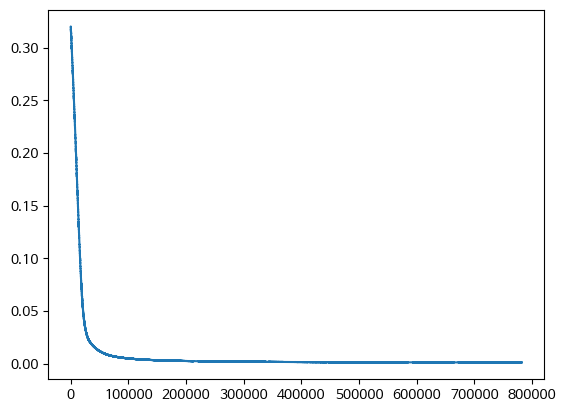

In [ ]:
plt.plot(loss_list)

In [16]:
# torch.save(model.state_dict(), 'result/lstm_full_parameters.pth')
model.load_state_dict(torch.load('result/lstm_full_parameters.pth'))

<All keys matched successfully>

In [ ]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

len_train = int(len(df_train)*0.8) # training 80% , validation 20%

X_train = X_ss[:len_train, :]
X_test = X_ss[len_train:, :]

y_train = y_ms[:len_train, :]
y_test = y_ms[len_train:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

Training Shape (24380, 71) (24380, 9)
Testing Shape (6095, 71) (6095, 9)


In [ ]:
df_x_ss = ss.transform(X)
df_y_ms = ms.transform(y)

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

In [ ]:
df_x_ss = df_x_ss.to(device)

train_predict = model(df_x_ss)


predicted = train_predict.cpu().data.numpy()
label_y = df_y_ms.data.numpy()
predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

In [ ]:
print(label_y.shape, predicted.shape)

(30475, 9) (30475, 9)


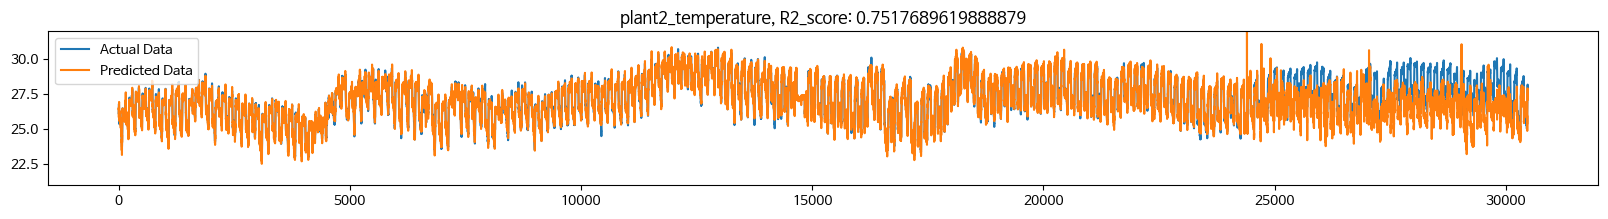

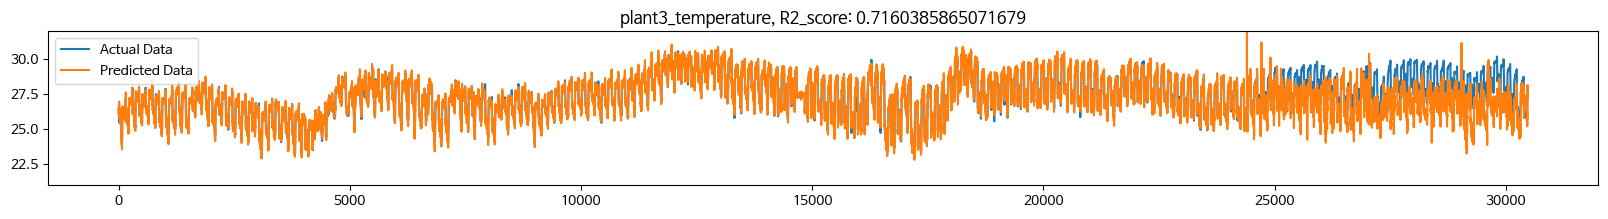

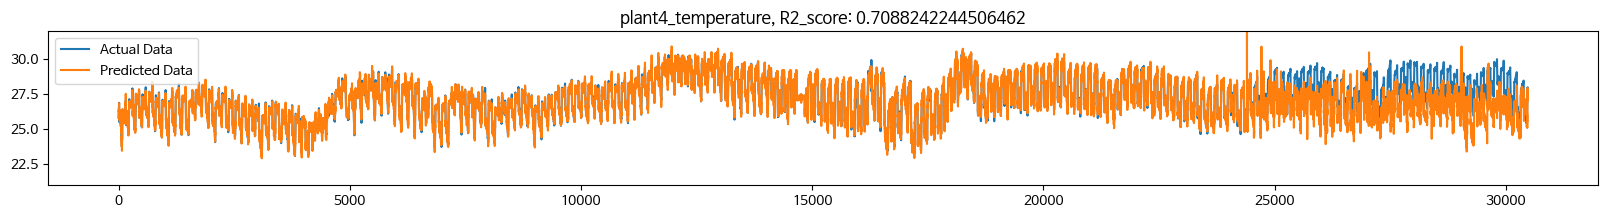

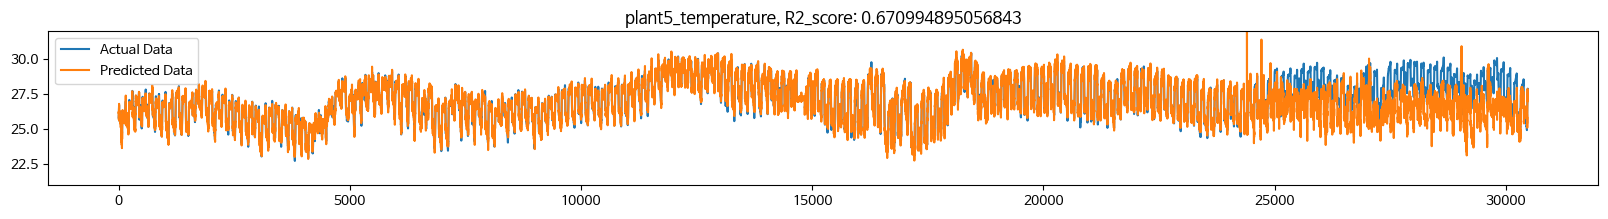

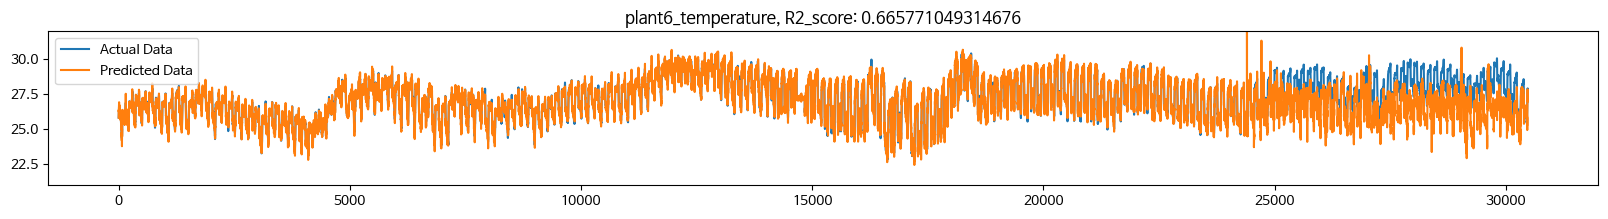

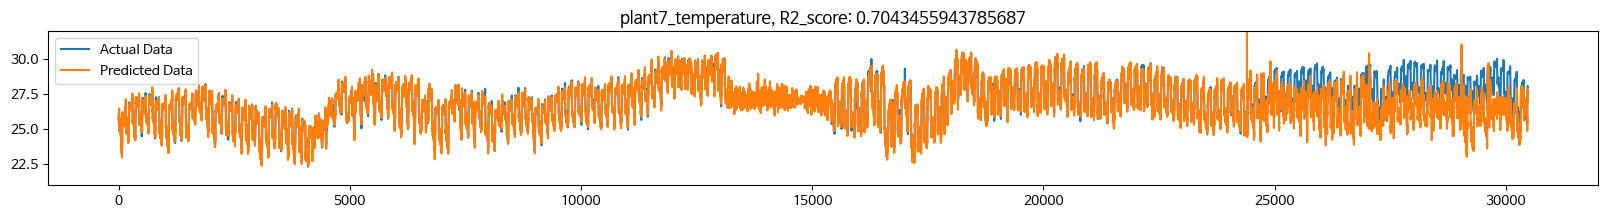

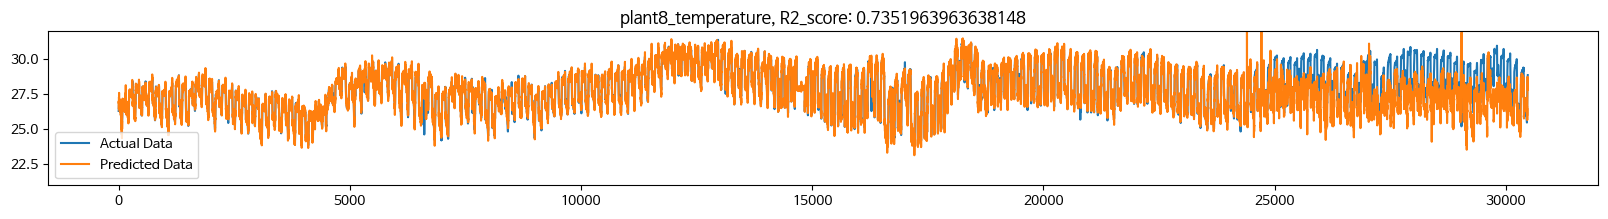

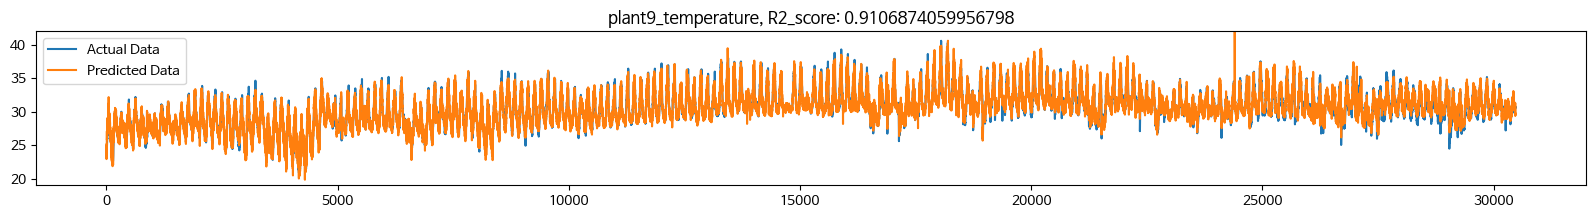

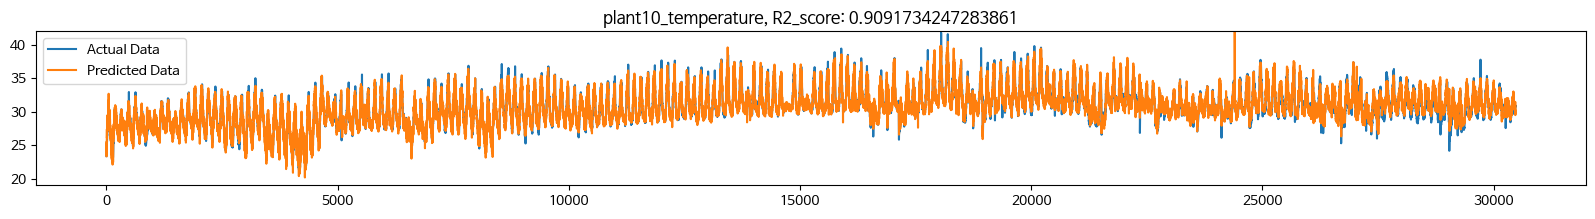

In [ ]:
# plt.axvline(x=200, c='r', linestyle='--')

for i in range(7):
  plt.figure(figsize=(20,2))
  plt.plot(label_y[:,i], label='Actual Data')
  plt.plot(predicted[:,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(label_y[:,i], predicted[:,i])}')
  plt.ylim(21,32)
  plt.legend()
  plt.show()

for i in range(7,9):
  plt.figure(figsize=(20,2))
  plt.plot(label_y[:,i], label='Actual Data')
  plt.plot(predicted[:,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(label_y[:,i], predicted[:,i])}')
  plt.ylim(19,42)
  plt.legend()
  plt.show()

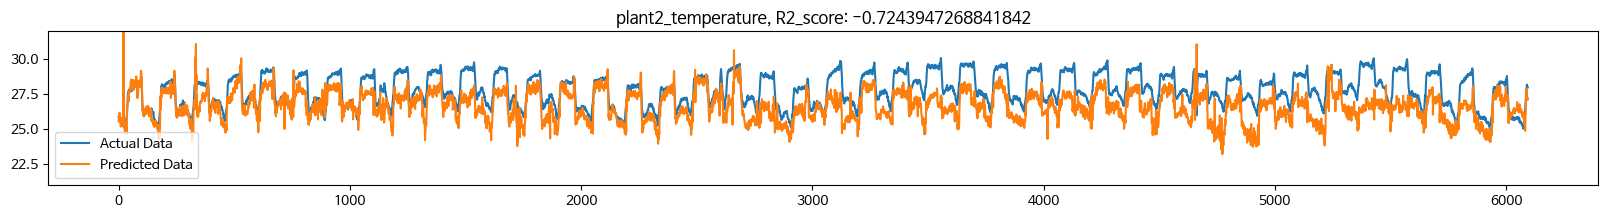

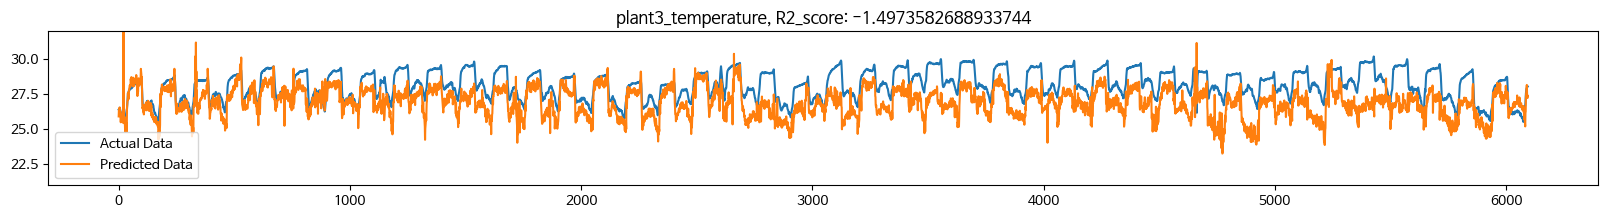

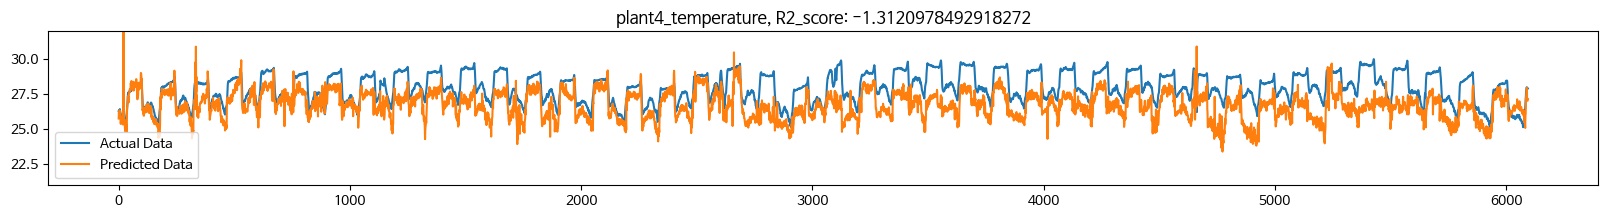

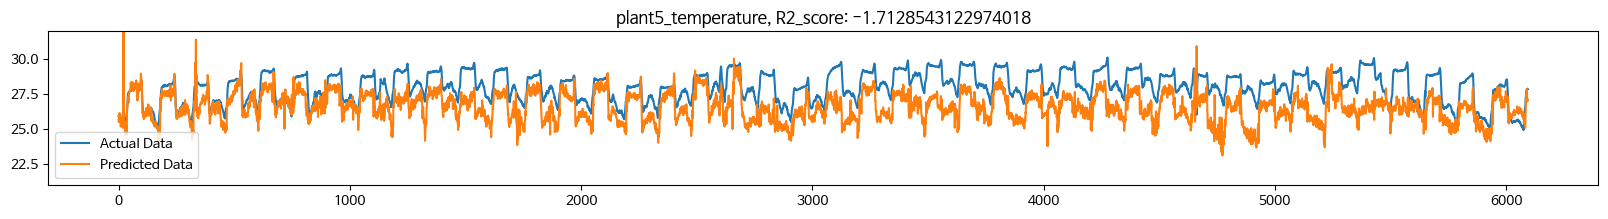

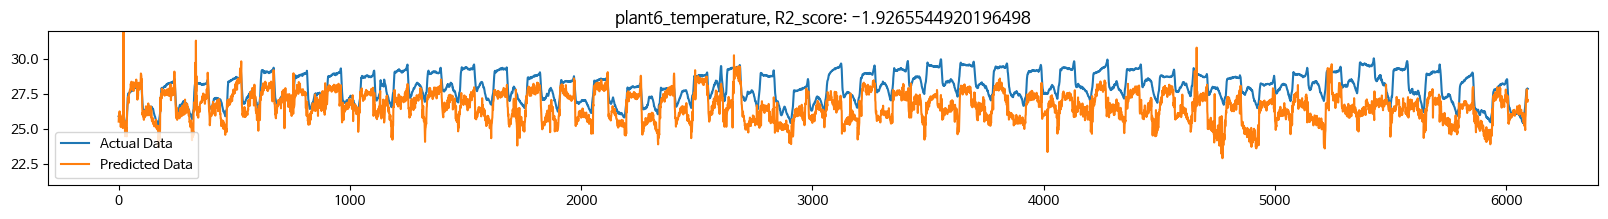

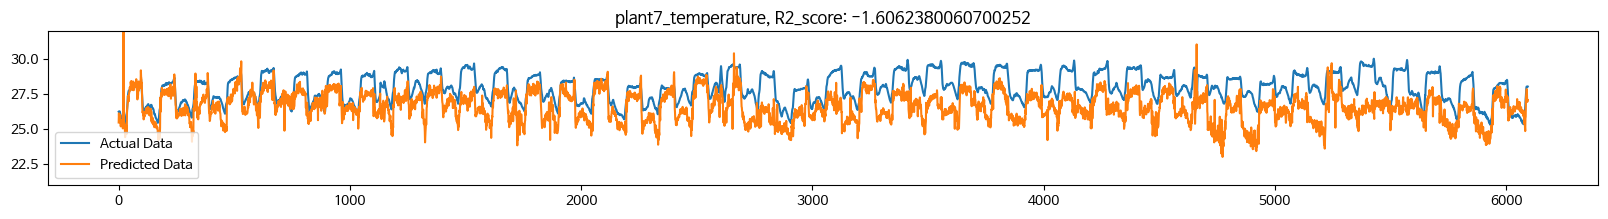

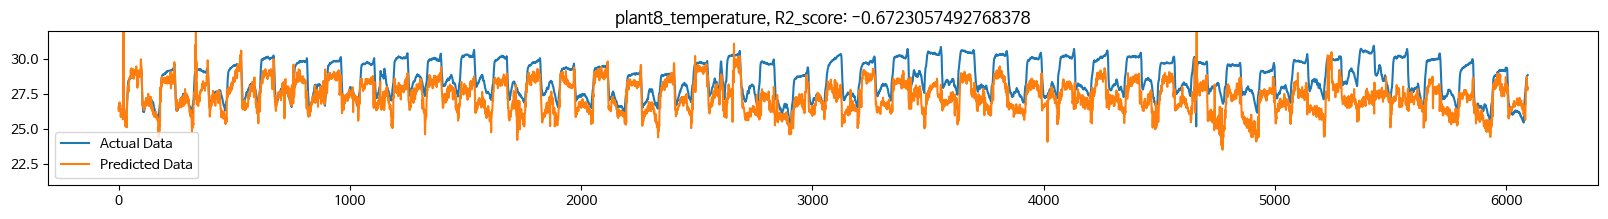

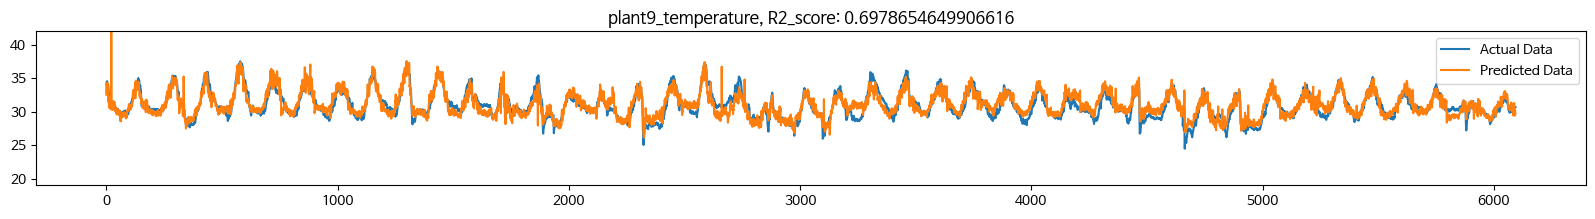

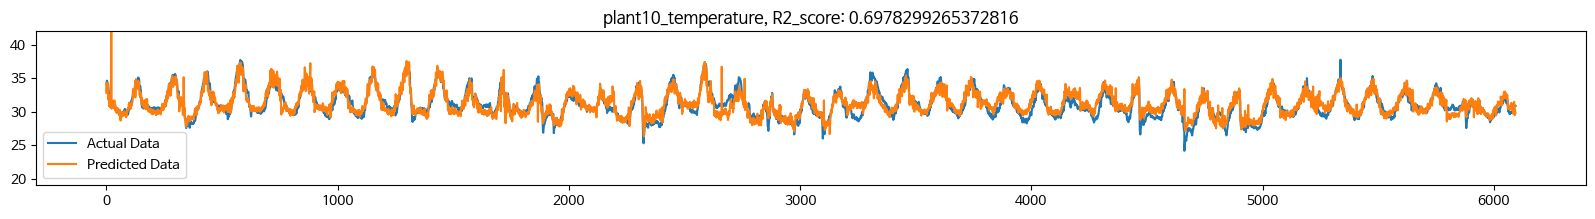

In [ ]:
# plt.axvline(x=200, c='r', linestyle='--')

for i in range(7):
  plt.figure(figsize=(20,2))
  plt.plot(label_y[len_train:,i], label='Actual Data')
  plt.plot(predicted[len_train:,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(label_y[len_train:,i], predicted[len_train:,i])}')
  plt.ylim(21,32)
  plt.legend()
  plt.show()

for i in range(7,9):
  plt.figure(figsize=(20,2))
  plt.plot(label_y[len_train:,i], label='Actual Data')
  plt.plot(predicted[len_train:,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(label_y[len_train:,i], predicted[len_train:,i])}')
  plt.ylim(19,42)
  plt.legend()
  plt.show()

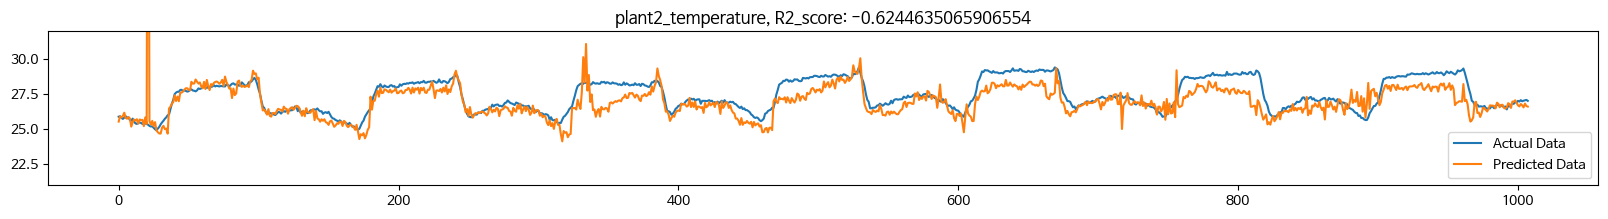

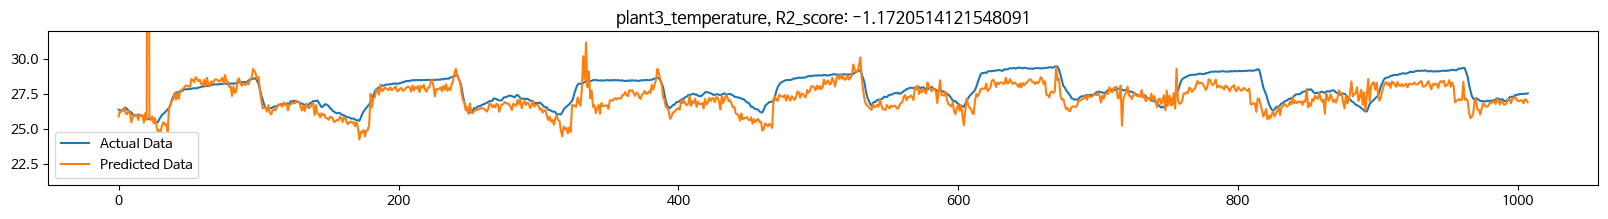

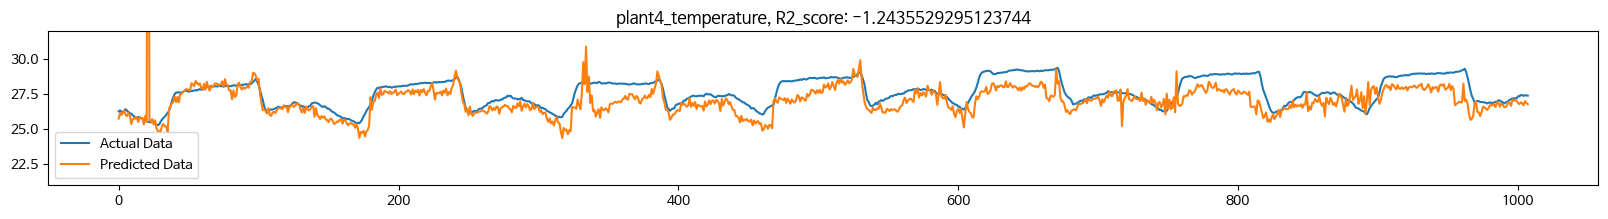

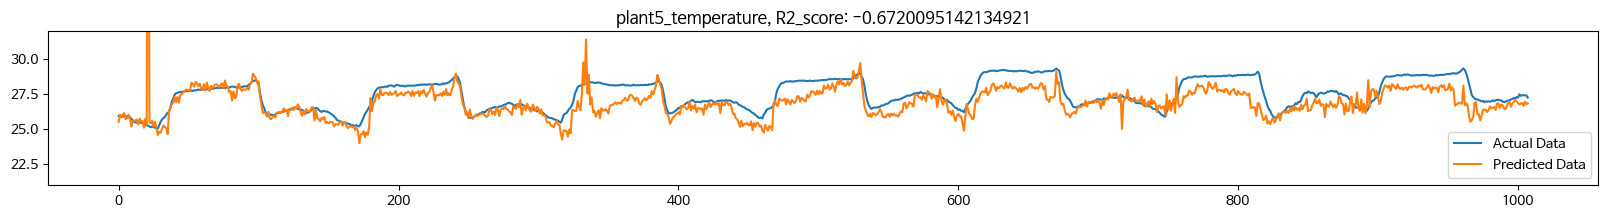

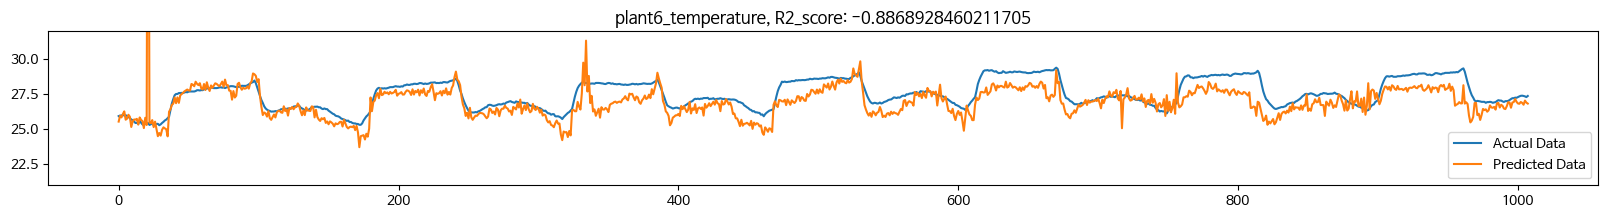

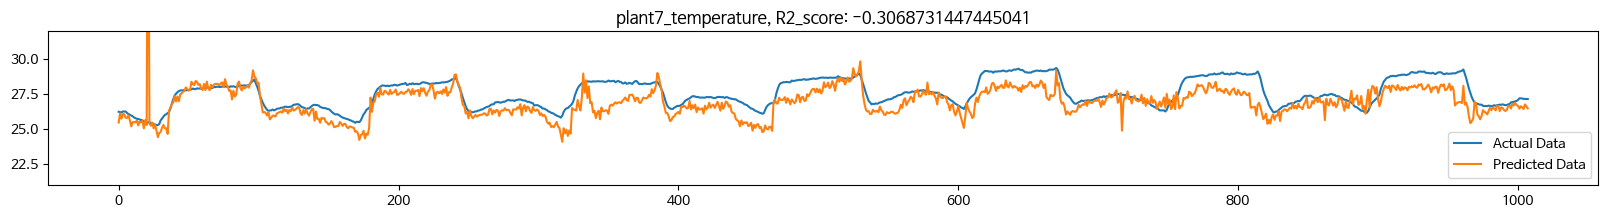

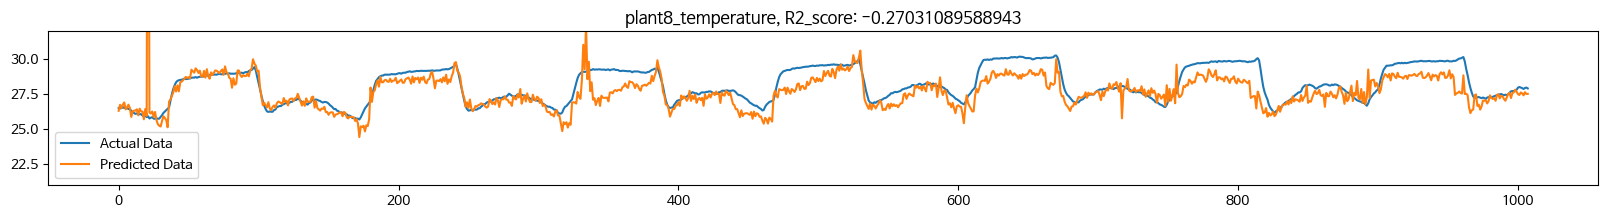

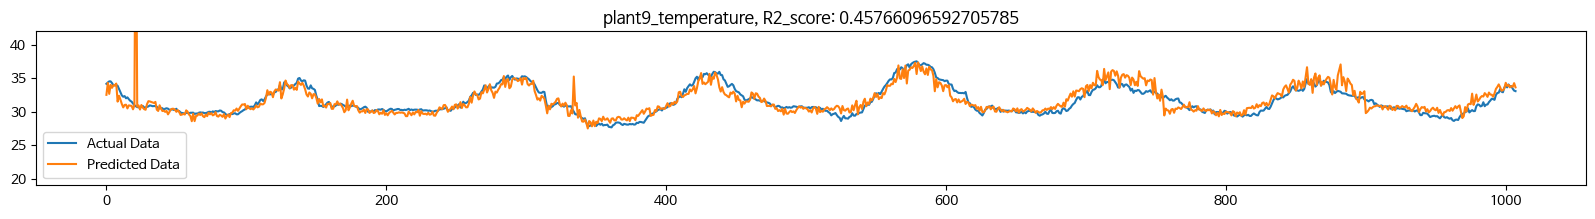

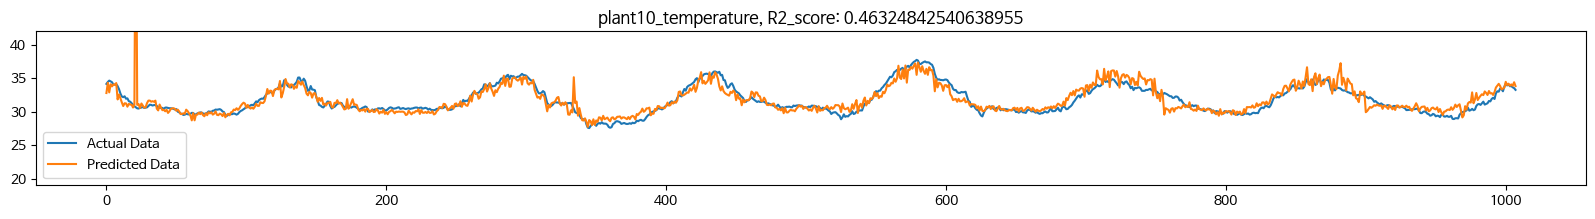

In [ ]:
# plt.axvline(x=200, c='r', linestyle='--')
for i in range(7):
  plt.figure(figsize=(20,2))
  plt.plot(label_y[len_train:len_train+6*24*7,i], label='Actual Data')
  plt.plot(predicted[len_train:len_train+6*24*7,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(label_y[len_train:len_train+6*24*7,i], predicted[len_train:len_train+6*24*7,i])}')
  plt.ylim(21,32)
  plt.legend()
  plt.show()

for i in range(7,9):
  plt.figure(figsize=(20,2))
  plt.plot(label_y[len_train:len_train+6*24*7,i], label='Actual Data')
  plt.plot(predicted[len_train:len_train+6*24*7,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(label_y[len_train:len_train+6*24*7,i], predicted[len_train:len_train+6*24*7,i])}')
  plt.ylim(19,42)
  plt.legend()
  plt.show()

In [18]:
yt = df_test.loc[:,target]
Xt = df_test.drop(columns=target)

df_x_ss = ss.transform(Xt)
df_y_ms = ms.transform(yt)

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

df_x_ss = df_x_ss.to(device)

train_predict = model(df_x_ss)


predicted = train_predict.cpu().data.numpy()
label_y = df_y_ms.data.numpy()
predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

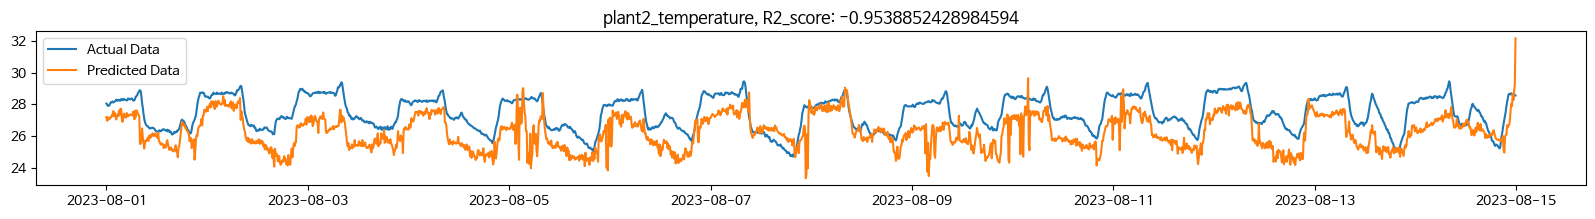

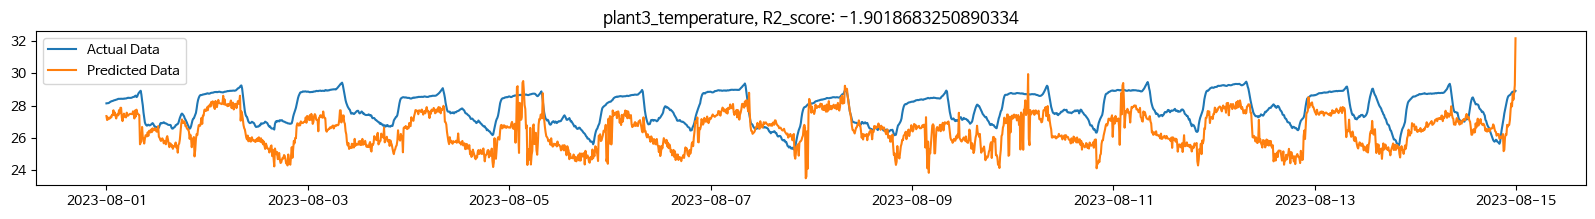

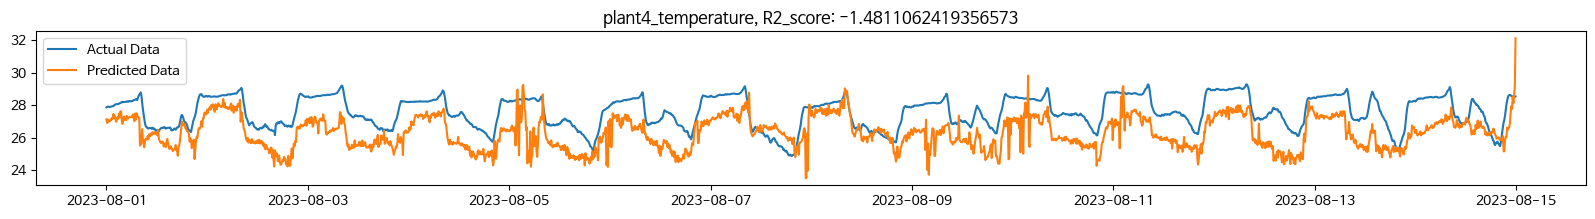

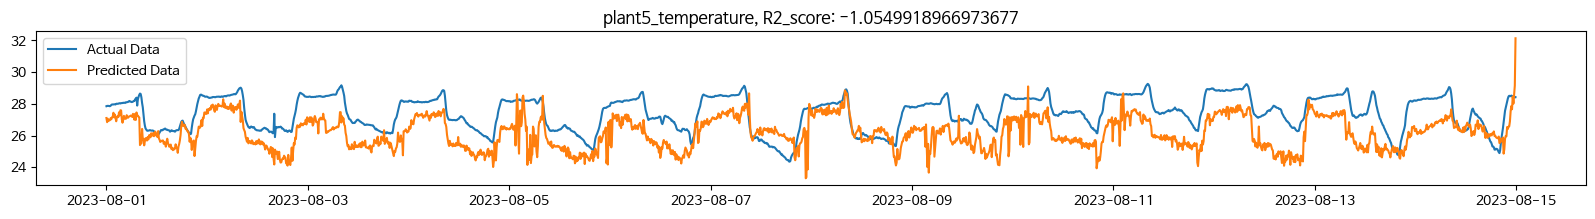

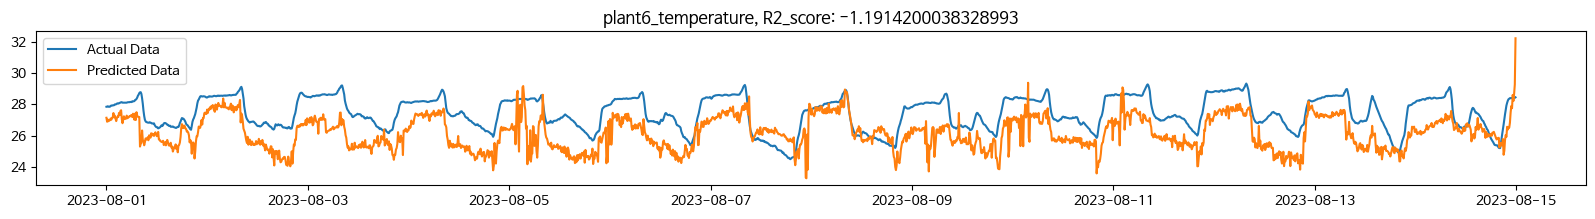

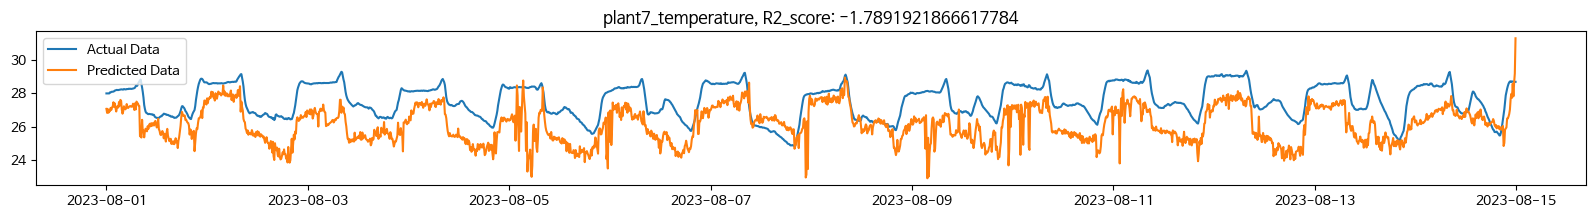

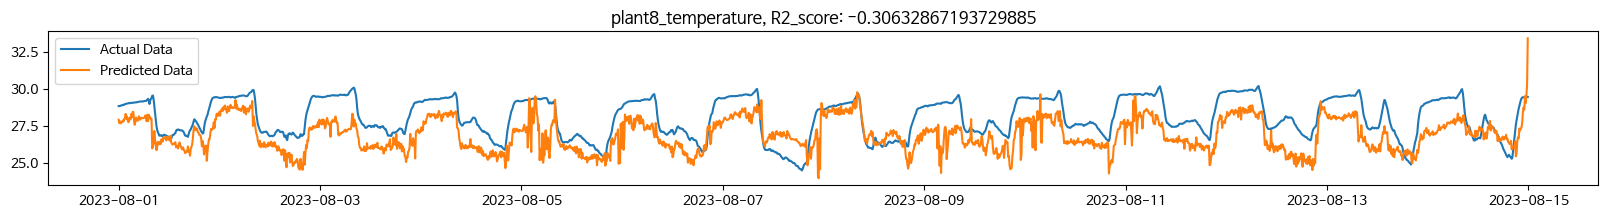

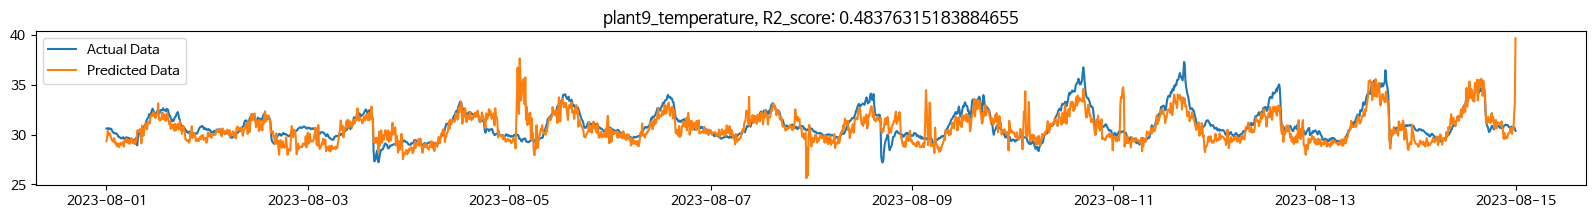

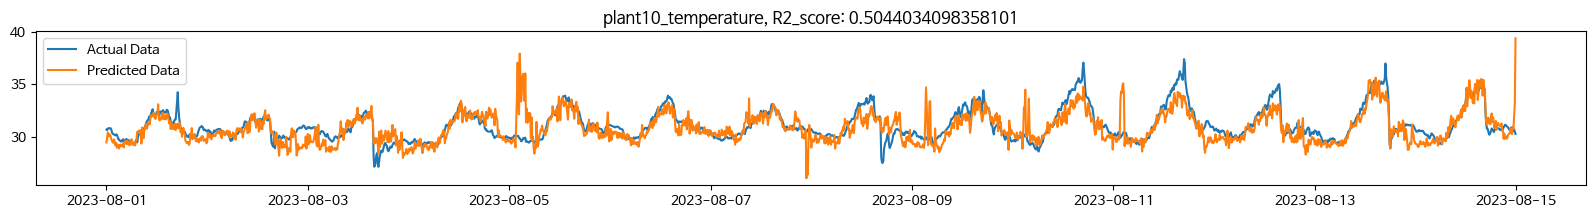

In [19]:
# plt.axvline(x=200, c='r', linestyle='--')
week2 = 2*7*24*6
start_date = "2023-08-01 00:00:00"
end_date = "2023-08-14 23:50:00"
date_range = pd.date_range(start=start_date, end=end_date, freq='10T')


for i in range(9):
  plt.figure(figsize=(20,2))
  plt.plot(date_range, label_y[:week2,i], label='Actual Data')
  plt.plot(date_range, predicted[:week2,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(label_y[:week2,i], predicted[:week2,i])}')
  plt.legend()
  plt.show()